In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
HDAC1 = Path(HERE).resolve().parents[1]/'input'

In [3]:
df = pd.read_pickle(HDAC1/"HDAC1_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1
0,CHEMBL3921050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[9593141, 5451723, 1098538, 7467572, 8519057, ...",6.17
1,CHEMBL270476,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13333824, 16015625, 6095547, 11013180, 106090...",6.80
2,CHEMBL3664128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[9238077, 2038275, 1578989, 1109593, 7780264, ...",7.62
3,CHEMBL4456250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[2167236, 3827191, 5190786, 7944578, 19973311,...",5.26
4,CHEMBL2408818,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2078792, 2722242, 5084638, 18495690, 845386, ...",6.32


In [4]:
df_labeled = pd.read_csv(HDAC1/"HDAC1_dataset.csv", )
df_labeled

,molecule_chembl_id,smiles,type,Standard_Value_HDAC1,pChEMBL_HDAC1,label
0,CHEMBL327146,O=C(CCCCCC(C(=O)Nc1ccc2ncccc2c1)C(=O)Nc1ccc2nc...,IC50,1.00,9.00,Single points
1,CHEMBL116620,O=C(/C=C/c1cccc(C(C(=O)Nc2ccccc2)C(=O)Nc2ccccc...,IC50,1.00,9.00,Single points
2,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,IC50,6300.00,5.20,Single points
3,CHEMBL316457,CC(C)c1cc(C(C)C)c(S(=O)(=O)Nc2ccc(/C=C/C(=O)NO...,IC50,600.00,6.22,Single points
4,CHEMBL269692,O=C(NCc1ccc(C(=O)NO)cc1)OCc1cccnc1,IC50,3000.00,5.52,Single points
...,...,...,...,...,...,...
4487,CHEMBL4649511,O=C(CCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,IC50,3.30,8.48,Dual-binder
4488,CHEMBL4637976,O=C(CCCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,IC50,130.00,6.89,Single points
4489,CHEMBL4638227,CC(=O)Nc1ccc2c(c1)CN(C(=O)[C@H](N)Cc1ccc(Cl)cc...,IC50,8800.00,5.06,Single points
4490,CHEMBL4444219,CCCNNC(=O)/C=C/c1ccc(CNCCc2c(C)[nH]c3ccccc23)cc1,IC50,4.85,8.43,Single points


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')
df.tail()

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1,label
4487,CHEMBL4250302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[5240905, 10949433, 5178223, 6083913, 2157755,...",10.25,Single points
4488,CHEMBL483893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","[2331191, 10511, 137380, 311785, 4030911, 7589...",7.83,Dual-binder
4489,CHEMBL3655914,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[8142946, 2478511, 10872982, 45638894, 4495368...",6.69,Semi-selective
4490,CHEMBL467876,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[668904, 10511, 2475943, 2183376, 3858537, 376...",7.40,Single points
4491,CHEMBL4458544,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[5976924, 3821889, 137380, 5264283, 1293667, 6...",7.37,Dual-binder


In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1,label,Class
0,CHEMBL3921050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[9593141, 5451723, 1098538, 7467572, 8519057, ...",6.17,Single points,0.0
1,CHEMBL270476,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13333824, 16015625, 6095547, 11013180, 106090...",6.80,Single points,0.0
2,CHEMBL3664128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[9238077, 2038275, 1578989, 1109593, 7780264, ...",7.62,Single points,0.0
3,CHEMBL4456250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[2167236, 3827191, 5190786, 7944578, 19973311,...",5.26,Single points,0.0


In [7]:
# Add column for activity
df["activity"] = np.zeros(len(df))

# Mark every molecule as active if pchembl value is >=6.6 0 otherwise
df.loc[df[df.pChEMBL_HDAC1 >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["pChEMBL_HDAC1"].values
Y_cat =  df["activity"].values
Y_class = df['Class'].values
indices =  np.array(df.index)


In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['pChEMBL_HDAC1'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['pChEMBL_HDAC1'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=16,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6) , 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.683104     0.021265
1                    TP       202.600000     9.477459
2                    TN       173.000000     8.137704
3                    FP        40.100000     5.173651
4                    FN        33.500000     3.894440
5              Accuracy         0.836143     0.015890
6             Precision         0.834744     0.020126
7           Sensitivity         0.857837     0.018346
8           Specificity         0.811790     0.023305
9              F1 score         0.846027     0.016609
10  F1 score (weighted)         0.835958     0.015952
11     F1 score (macro)         0.835253     0.015811
12    Balanced Accuracy         0.834818     0.015701
13                  MCC         0.671119     0.031278
14                  NPV         0.837860     0.016747
15              ROC_AUC         0.834818     0.015701
CPU times: user 3min 31s, sys: 199 ms, total: 3min 31s
Wall time: 16.8 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=16, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=16, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 15:44:36,393] A new study created in memory with name: RFRegressor
[I 2023-12-19 15:46:19,501] Trial 0 finished with value: 0.6593277125817122 and parameters: {'n_estimators': 882}. Best is trial 0 with value: 0.6593277125817122.
[I 2023-12-19 15:47:06,860] Trial 1 finished with value: 0.6595631944145943 and parameters: {'n_estimators': 333}. Best is trial 1 with value: 0.6595631944145943.
[I 2023-12-19 15:48:13,621] Trial 2 finished with value: 0.659567485985713 and parameters: {'n_estimators': 451}. Best is trial 2 with value: 0.659567485985713.
[I 2023-12-19 15:48:58,269] Trial 3 finished with value: 0.6598410246877591 and parameters: {'n_estimators': 299}. Best is trial 3 with value: 0.6598410246877591.
[I 2023-12-19 15:50:43,301] Trial 4 finished with value: 0.6596743102534252 and parameters: {'n_estimators': 662}. Best is trial 3 with value: 0.6598410246877591.
[I 2023-12-19 15:53:13,507] Trial 5 finished with value: 0.6593471455795259 and parameters: {'n_estimators

	Number of trials: 50.0
	Best value (r2_score): 0.6599
	Best params:
		n_estimators: 304


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_0_cat = np.where((y_pred_rf_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.681289
1                    TP  401.000000
2                    TN  328.000000
3                    FP   98.000000
4                    FN   72.000000
5              Accuracy    0.810901
6             Precision    0.803607
7           Sensitivity    0.847780
8           Specificity    0.770000
9              F1 score    0.825103
10  F1 score (weighted)    0.810454
11     F1 score (macro)    0.809646
12    Balanced Accuracy    0.808867
13                  MCC    0.620663
14                  NPV    0.820000
15              ROC_AUC    0.808867


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 16:41:20,427] Trial 50 finished with value: 0.6563318710879945 and parameters: {'n_estimators': 757}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 16:42:03,593] Trial 51 finished with value: 0.6562866291969623 and parameters: {'n_estimators': 232}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 16:42:41,871] Trial 52 finished with value: 0.6562083894750074 and parameters: {'n_estimators': 201}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 16:43:19,498] Trial 53 finished with value: 0.6561183945798204 and parameters: {'n_estimators': 204}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 16:44:07,545] Trial 54 finished with value: 0.6564324490953268 and parameters: {'n_estimators': 255}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 16:45:00,865] Trial 55 finished with value: 0.6563967715735664 and parameters: {'n_estimators': 299}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12

	Number of trials: 100.0
	Best value (r2_score): 0.6599
	Best params:
		n_estimators: 304


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_1_cat = np.where((y_pred_rf_1 >= 6.6), 1, 0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.681289    0.690470
1                    TP  401.000000  407.000000
2                    TN  328.000000  333.000000
3                    FP   98.000000   89.000000
4                    FN   72.000000   70.000000
5              Accuracy    0.810901    0.823137
6             Precision    0.803607    0.820565
7           Sensitivity    0.847780    0.853249
8           Specificity    0.770000    0.789100
9              F1 score    0.825103    0.836588
10  F1 score (weighted)    0.810454    0.822827
11     F1 score (macro)    0.809646    0.821930
12    Balanced Accuracy    0.808867    0.821175
13                  MCC    0.620663    0.644604
14                  NPV    0.820000    0.826300
15              ROC_AUC    0.808867    0.821175


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 17:28:38,461] Trial 100 finished with value: 0.6577270594718856 and parameters: {'n_estimators': 478}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 17:29:38,345] Trial 101 finished with value: 0.6571670645185546 and parameters: {'n_estimators': 346}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 17:30:49,729] Trial 102 finished with value: 0.6575059733850119 and parameters: {'n_estimators': 397}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 17:31:46,635] Trial 103 finished with value: 0.6571177078355015 and parameters: {'n_estimators': 322}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 17:32:33,842] Trial 104 finished with value: 0.6568369569086736 and parameters: {'n_estimators': 268}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 17:33:29,529] Trial 105 finished with value: 0.6570390700999298 and parameters: {'n_estimators': 311}. Best is trial 26 with value: 0.6599194417857677.
[I 2

	Number of trials: 150.0
	Best value (r2_score): 0.6599
	Best params:
		n_estimators: 304


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_2_cat = np.where((y_pred_rf_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.681289    0.690470    0.678922
1                    TP  401.000000  407.000000  374.000000
2                    TN  328.000000  333.000000  362.000000
3                    FP   98.000000   89.000000   90.000000
4                    FN   72.000000   70.000000   73.000000
5              Accuracy    0.810901    0.823137    0.818687
6             Precision    0.803607    0.820565    0.806034
7           Sensitivity    0.847780    0.853249    0.836689
8           Specificity    0.770000    0.789100    0.800900
9              F1 score    0.825103    0.836588    0.821076
10  F1 score (weighted)    0.810454    0.822827    0.818642
11     F1 score (macro)    0.809646    0.821930    0.818655
12    Balanced Accuracy    0.808867    0.821175    0.818787
13                  MCC    0.620663    0.644604    0.637896
14                  NPV    0.820000    0.826300    0.832200
15              ROC_AUC    0.808867    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 18:19:51,597] Trial 150 finished with value: 0.6503365093690437 and parameters: {'n_estimators': 380}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 18:20:49,950] Trial 151 finished with value: 0.6500517237562272 and parameters: {'n_estimators': 330}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 18:21:41,954] Trial 152 finished with value: 0.6497152742282378 and parameters: {'n_estimators': 289}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 18:22:28,233] Trial 153 finished with value: 0.6496370045592766 and parameters: {'n_estimators': 257}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 18:23:09,810] Trial 154 finished with value: 0.649464335576962 and parameters: {'n_estimators': 237}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 18:23:49,323] Trial 155 finished with value: 0.6493060842602841 and parameters: {'n_estimators': 214}. Best is trial 26 with value: 0.6599194417857677.
[I 20

	Number of trials: 200.0
	Best value (r2_score): 0.6599
	Best params:
		n_estimators: 304


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_3_cat = np.where((y_pred_rf_3 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.681289    0.690470    0.678922    0.680260
1                    TP  401.000000  407.000000  374.000000  409.000000
2                    TN  328.000000  333.000000  362.000000  345.000000
3                    FP   98.000000   89.000000   90.000000   75.000000
4                    FN   72.000000   70.000000   73.000000   70.000000
5              Accuracy    0.810901    0.823137    0.818687    0.838710
6             Precision    0.803607    0.820565    0.806034    0.845041
7           Sensitivity    0.847780    0.853249    0.836689    0.853862
8           Specificity    0.770000    0.789100    0.800900    0.821400
9              F1 score    0.825103    0.836588    0.821076    0.849429
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888
12    Balanced Accuracy    0.808867    0.821175    0.818787    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 19:03:19,927] Trial 200 finished with value: 0.6579080781421153 and parameters: {'n_estimators': 367}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 19:04:34,476] Trial 201 finished with value: 0.6583565179458077 and parameters: {'n_estimators': 408}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 19:05:49,542] Trial 202 finished with value: 0.6588999891511336 and parameters: {'n_estimators': 429}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 19:06:58,511] Trial 203 finished with value: 0.6583549159055766 and parameters: {'n_estimators': 385}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 19:07:36,216] Trial 204 finished with value: 0.6570031847921725 and parameters: {'n_estimators': 222}. Best is trial 26 with value: 0.6599194417857677.
[I 2023-12-19 19:08:36,241] Trial 205 finished with value: 0.6578488167528025 and parameters: {'n_estimators': 334}. Best is trial 26 with value: 0.6599194417857677.
[I 2

	Number of trials: 250.0
	Best value (r2_score): 0.6599
	Best params:
		n_estimators: 304


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_4_cat = np.where((y_pred_rf_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681289    0.690470    0.678922    0.680260   
1                    TP  401.000000  407.000000  374.000000  409.000000   
2                    TN  328.000000  333.000000  362.000000  345.000000   
3                    FP   98.000000   89.000000   90.000000   75.000000   
4                    FN   72.000000   70.000000   73.000000   70.000000   
5              Accuracy    0.810901    0.823137    0.818687    0.838710   
6             Precision    0.803607    0.820565    0.806034    0.845041   
7           Sensitivity    0.847780    0.853249    0.836689    0.853862   
8           Specificity    0.770000    0.789100    0.800900    0.821400   
9              F1 score    0.825103    0.836588    0.821076    0.849429   
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645   
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 19:57:59,714] Trial 250 finished with value: 0.6668360520104661 and parameters: {'n_estimators': 250}. Best is trial 250 with value: 0.6668360520104661.
[I 2023-12-19 19:58:44,951] Trial 251 finished with value: 0.6667645505988367 and parameters: {'n_estimators': 248}. Best is trial 250 with value: 0.6668360520104661.
[I 2023-12-19 19:59:32,217] Trial 252 finished with value: 0.6668127990554794 and parameters: {'n_estimators': 252}. Best is trial 250 with value: 0.6668360520104661.
[I 2023-12-19 20:00:15,046] Trial 253 finished with value: 0.6667549694527258 and parameters: {'n_estimators': 247}. Best is trial 250 with value: 0.6668360520104661.
[I 2023-12-19 20:01:03,539] Trial 254 finished with value: 0.6669004019733945 and parameters: {'n_estimators': 262}. Best is trial 254 with value: 0.6669004019733945.
[I 2023-12-19 20:01:52,563] Trial 255 finished with value: 0.6668071607709283 and parameters: {'n_estimators': 257}. Best is trial 254 with value: 0.6669004019733945

	Number of trials: 300.0
	Best value (r2_score): 0.6676
	Best params:
		n_estimators: 296


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_5_cat = np.where((y_pred_rf_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681289    0.690470    0.678922    0.680260   
1                    TP  401.000000  407.000000  374.000000  409.000000   
2                    TN  328.000000  333.000000  362.000000  345.000000   
3                    FP   98.000000   89.000000   90.000000   75.000000   
4                    FN   72.000000   70.000000   73.000000   70.000000   
5              Accuracy    0.810901    0.823137    0.818687    0.838710   
6             Precision    0.803607    0.820565    0.806034    0.845041   
7           Sensitivity    0.847780    0.853249    0.836689    0.853862   
8           Specificity    0.770000    0.789100    0.800900    0.821400   
9              F1 score    0.825103    0.836588    0.821076    0.849429   
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645   
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 20:39:18,463] Trial 300 finished with value: 0.6551146089680631 and parameters: {'n_estimators': 299}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 20:40:09,680] Trial 301 finished with value: 0.6550797960245603 and parameters: {'n_estimators': 296}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 20:41:02,807] Trial 302 finished with value: 0.6550068011702933 and parameters: {'n_estimators': 292}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 20:41:56,802] Trial 303 finished with value: 0.655138445090795 and parameters: {'n_estimators': 300}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 20:42:46,661] Trial 304 finished with value: 0.6550804751817786 and parameters: {'n_estimators': 295}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 20:43:38,514] Trial 305 finished with value: 0.6549767641697335 and parameters: {'n_estimators': 303}. Best is trial 291 with value: 0.6675737200677461.

	Number of trials: 350.0
	Best value (r2_score): 0.6676
	Best params:
		n_estimators: 296


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_6_cat = np.where((y_pred_rf_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681289    0.690470    0.678922    0.680260   
1                    TP  401.000000  407.000000  374.000000  409.000000   
2                    TN  328.000000  333.000000  362.000000  345.000000   
3                    FP   98.000000   89.000000   90.000000   75.000000   
4                    FN   72.000000   70.000000   73.000000   70.000000   
5              Accuracy    0.810901    0.823137    0.818687    0.838710   
6             Precision    0.803607    0.820565    0.806034    0.845041   
7           Sensitivity    0.847780    0.853249    0.836689    0.853862   
8           Specificity    0.770000    0.789100    0.800900    0.821400   
9              F1 score    0.825103    0.836588    0.821076    0.849429   
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645   
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 21:21:27,805] Trial 350 finished with value: 0.6577221620838902 and parameters: {'n_estimators': 292}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 21:22:18,078] Trial 351 finished with value: 0.6572568230653318 and parameters: {'n_estimators': 270}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 21:23:11,304] Trial 352 finished with value: 0.6578621551884746 and parameters: {'n_estimators': 312}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 21:23:57,813] Trial 353 finished with value: 0.6572821051443701 and parameters: {'n_estimators': 268}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 21:24:51,153] Trial 354 finished with value: 0.6577221620838902 and parameters: {'n_estimators': 292}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 21:25:35,234] Trial 355 finished with value: 0.6574244033166716 and parameters: {'n_estimators': 245}. Best is trial 291 with value: 0.6675737200677461

	Number of trials: 400.0
	Best value (r2_score): 0.6676
	Best params:
		n_estimators: 296


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_7_cat = np.where((y_pred_rf_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681289    0.690470    0.678922    0.680260   
1                    TP  401.000000  407.000000  374.000000  409.000000   
2                    TN  328.000000  333.000000  362.000000  345.000000   
3                    FP   98.000000   89.000000   90.000000   75.000000   
4                    FN   72.000000   70.000000   73.000000   70.000000   
5              Accuracy    0.810901    0.823137    0.818687    0.838710   
6             Precision    0.803607    0.820565    0.806034    0.845041   
7           Sensitivity    0.847780    0.853249    0.836689    0.853862   
8           Specificity    0.770000    0.789100    0.800900    0.821400   
9              F1 score    0.825103    0.836588    0.821076    0.849429   
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645   
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 22:06:42,000] Trial 400 finished with value: 0.664079801758339 and parameters: {'n_estimators': 310}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 22:07:29,473] Trial 401 finished with value: 0.6646020569786777 and parameters: {'n_estimators': 269}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 22:08:19,230] Trial 402 finished with value: 0.6643178372728918 and parameters: {'n_estimators': 283}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 22:09:03,307] Trial 403 finished with value: 0.6645188225644499 and parameters: {'n_estimators': 253}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 22:09:56,435] Trial 404 finished with value: 0.6641455527965686 and parameters: {'n_estimators': 307}. Best is trial 291 with value: 0.6675737200677461.
[I 2023-12-19 22:10:52,516] Trial 405 finished with value: 0.6637110742836949 and parameters: {'n_estimators': 322}. Best is trial 291 with value: 0.6675737200677461.

	Number of trials: 450.0
	Best value (r2_score): 0.6676
	Best params:
		n_estimators: 296


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_8_cat = np.where((y_pred_rf_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681289    0.690470    0.678922    0.680260   
1                    TP  401.000000  407.000000  374.000000  409.000000   
2                    TN  328.000000  333.000000  362.000000  345.000000   
3                    FP   98.000000   89.000000   90.000000   75.000000   
4                    FN   72.000000   70.000000   73.000000   70.000000   
5              Accuracy    0.810901    0.823137    0.818687    0.838710   
6             Precision    0.803607    0.820565    0.806034    0.845041   
7           Sensitivity    0.847780    0.853249    0.836689    0.853862   
8           Specificity    0.770000    0.789100    0.800900    0.821400   
9              F1 score    0.825103    0.836588    0.821076    0.849429   
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645   
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 22:49:18,123] Trial 450 finished with value: 0.6770450722722531 and parameters: {'n_estimators': 285}. Best is trial 450 with value: 0.6770450722722531.
[I 2023-12-19 22:50:17,751] Trial 451 finished with value: 0.6776311526539046 and parameters: {'n_estimators': 337}. Best is trial 451 with value: 0.6776311526539046.
[I 2023-12-19 22:51:16,865] Trial 452 finished with value: 0.6776925124064742 and parameters: {'n_estimators': 338}. Best is trial 452 with value: 0.6776925124064742.
[I 2023-12-19 22:52:17,642] Trial 453 finished with value: 0.6777109446434624 and parameters: {'n_estimators': 339}. Best is trial 453 with value: 0.6777109446434624.
[I 2023-12-19 22:53:17,588] Trial 454 finished with value: 0.6775726005439362 and parameters: {'n_estimators': 346}. Best is trial 453 with value: 0.6777109446434624.
[I 2023-12-19 22:54:18,507] Trial 455 finished with value: 0.6775980617130125 and parameters: {'n_estimators': 347}. Best is trial 453 with value: 0.6777109446434624

	Number of trials: 500.0
	Best value (r2_score): 0.6782
	Best params:
		n_estimators: 407


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_9_cat = np.where((y_pred_rf_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681289    0.690470    0.678922    0.680260   
1                    TP  401.000000  407.000000  374.000000  409.000000   
2                    TN  328.000000  333.000000  362.000000  345.000000   
3                    FP   98.000000   89.000000   90.000000   75.000000   
4                    FN   72.000000   70.000000   73.000000   70.000000   
5              Accuracy    0.810901    0.823137    0.818687    0.838710   
6             Precision    0.803607    0.820565    0.806034    0.845041   
7           Sensitivity    0.847780    0.853249    0.836689    0.853862   
8           Specificity    0.770000    0.789100    0.800900    0.821400   
9              F1 score    0.825103    0.836588    0.821076    0.849429   
10  F1 score (weighted)    0.810454    0.822827    0.818642    0.838645   
11     F1 score (macro)    0.809646    0.821930    0.818655    0.837888   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.6782
	Best params:
		n_estimators: 407


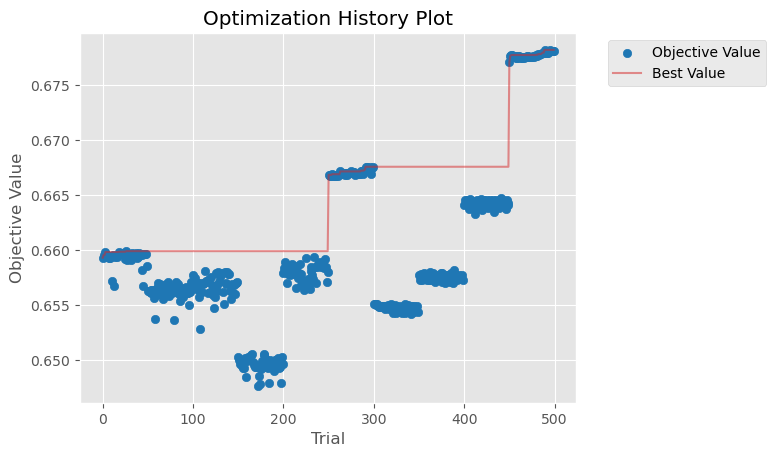

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.684966,0.018239
1,TP,202.900000,8.862530
2,TN,172.700000,6.832114
3,FP,40.400000,3.835507
4,FN,33.200000,3.938415
5,Accuracy,0.836146,0.011753
6,Precision,0.833810,0.015976
7,Sensitivity,0.859201,0.018004
8,Specificity,0.810450,0.016031
9,F1 score,0.846208,0.013750


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.681289,0.690470,0.678922,0.680260,0.674801,0.657296,0.656789,0.662378,0.686148,0.656025,0.672438,0.013102
1,TP,401.000000,407.000000,374.000000,409.000000,413.000000,392.000000,408.000000,416.000000,412.000000,395.000000,402.700000,12.719626
2,TN,328.000000,333.000000,362.000000,345.000000,339.000000,352.000000,340.000000,333.000000,337.000000,340.000000,340.900000,9.982763
3,FP,98.000000,89.000000,90.000000,75.000000,84.000000,86.000000,89.000000,80.000000,89.000000,103.000000,88.300000,8.056054
4,FN,72.000000,70.000000,73.000000,70.000000,63.000000,69.000000,62.000000,70.000000,61.000000,61.000000,67.100000,4.771443
5,Accuracy,0.810901,0.823137,0.818687,0.838710,0.836485,0.827586,0.832036,0.833148,0.833148,0.817575,0.827141,0.009191
6,Precision,0.803607,0.820565,0.806034,0.845041,0.830986,0.820084,0.820926,0.838710,0.822355,0.793173,0.820148,0.015944
7,Sensitivity,0.847780,0.853249,0.836689,0.853862,0.867647,0.850325,0.868085,0.855967,0.871036,0.866228,0.857087,0.010982
8,Specificity,0.770000,0.789100,0.800900,0.821400,0.801400,0.803700,0.792500,0.806300,0.791100,0.767500,0.794390,0.016364
9,F1 score,0.825103,0.836588,0.821076,0.849429,0.848921,0.834931,0.843847,0.847251,0.845996,0.828092,0.838123,0.010519


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=1121218, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,CHEMBL3921050,0,6.17,5.745405,5.777961,5.752727,5.792752,5.737715,5.829427,0.153480
1,CHEMBL270476,1,6.80,6.513853,6.673002,6.596345,6.755946,6.560680,6.649971,0.102994
2,CHEMBL3664128,2,7.62,6.985934,6.982142,6.807652,7.017887,6.862733,7.046058,0.267192
3,CHEMBL4456250,3,5.26,5.871720,5.953489,5.916302,5.820229,5.850442,5.778697,0.235959
4,CHEMBL2408818,4,6.32,6.294889,6.190686,6.228387,6.184382,6.180012,6.233059,0.055351
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4250302,4487,10.25,9.101310,8.978829,9.015004,9.116962,8.946996,9.234850,0.458075
4488,CHEMBL483893,4488,7.83,8.022598,7.975680,7.753303,7.905447,7.946143,7.905528,0.090511
4489,CHEMBL3655914,4489,6.69,6.682162,6.682975,6.750413,6.694152,6.696839,6.699424,0.023423
4490,CHEMBL467876,4490,7.40,7.177964,7.187125,7.201744,7.161826,7.233759,7.227070,0.080472


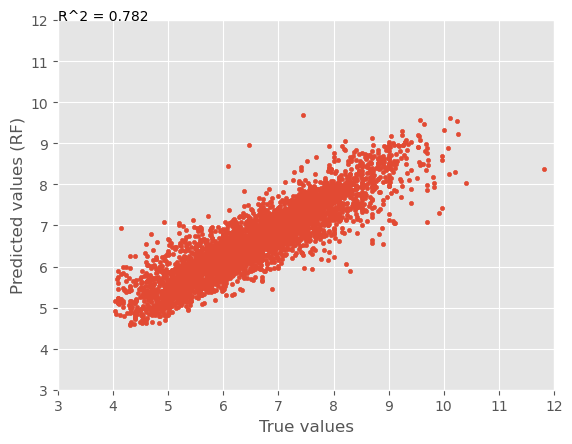

In [38]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (3, 12))
plt.show()

In [39]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.6803 with a standard deviation of 0.0201
RF optimized model r2_score 0.6822 with a standard deviation of 0.0204


In [40]:
joblib.dump(rf_reg, "OUTPUT/rf_reg.joblib")
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf.joblib")

['OUTPUT/optimizedCV_rf.joblib']

## LGBMRegressor

In [41]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=16,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.666572     0.018482
1                    TP       196.200000     5.921711
2                    TN       170.600000     5.777350
3                    FP        42.500000     5.060742
4                    FN        39.900000     6.297266
5              Accuracy         0.816563     0.011010
6             Precision         0.822140     0.018438
7           Sensitivity         0.831347     0.023445
8           Specificity         0.800840     0.019826
9              F1 score         0.826372     0.011142
10  F1 score (weighted)         0.816510     0.010956
11     F1 score (macro)         0.815876     0.010971
12    Balanced Accuracy         0.816093     0.010824
13                  MCC         0.632586     0.022058
14                  NPV         0.810840     0.026209
15              ROC_AUC         0.816093     0.010824
CPU times: user 43.5 s, sys: 156 ms, total: 43.7 s
Wall time: 2.97 s


In [42]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [43]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [44]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 23:53:27,190] A new study created in memory with name: lgbmRegressor
[I 2023-12-19 23:53:30,752] Trial 0 finished with value: 0.6601916797955442 and parameters: {'n_estimators': 808, 'learning_rate': 0.17006849684275036, 'max_depth': 6, 'max_bin': 235, 'num_leaves': 552}. Best is trial 0 with value: 0.6601916797955442.
[I 2023-12-19 23:53:32,723] Trial 1 finished with value: 0.6503410065411449 and parameters: {'n_estimators': 73, 'learning_rate': 0.18130944829005818, 'max_depth': 12, 'max_bin': 299, 'num_leaves': 190}. Best is trial 0 with value: 0.6601916797955442.
[I 2023-12-19 23:53:40,916] Trial 2 finished with value: 0.6240651300172317 and parameters: {'n_estimators': 432, 'learning_rate': 0.016830317475350274, 'max_depth': 8, 'max_bin': 264, 'num_leaves': 363}. Best is trial 0 with value: 0.6601916797955442.
[I 2023-12-19 23:53:44,411] Trial 3 finished with value: 0.6565936931808236 and parameters: {'n_estimators': 598, 'learning_rate': 0.1211702986291031, 'max_dept

	Number of trials: 50.0
	Best value (r2_score): 0.6820
	Best params:
		n_estimators: 852
		learning_rate: 0.10340146316890783
		max_depth: 12
		max_bin: 285
		num_leaves: 84


In [45]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_0_cat = np.where((y_pred_lgbm_0>= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.682897
1                    TP  396.000000
2                    TN  341.000000
3                    FP   85.000000
4                    FN   77.000000
5              Accuracy    0.819800
6             Precision    0.823285
7           Sensitivity    0.837209
8           Specificity    0.800500
9              F1 score    0.830189
10  F1 score (weighted)    0.819701
11     F1 score (macro)    0.819123
12    Balanced Accuracy    0.818839
13                  MCC    0.638376
14                  NPV    0.815800
15              ROC_AUC    0.818839


In [46]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 23:58:03,668] Trial 50 finished with value: 0.6678424912504921 and parameters: {'n_estimators': 771, 'learning_rate': 0.11603625043579888, 'max_depth': 11, 'max_bin': 292, 'num_leaves': 141}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-19 23:58:08,697] Trial 51 finished with value: 0.6620695953086513 and parameters: {'n_estimators': 709, 'learning_rate': 0.09935212280261914, 'max_depth': 10, 'max_bin': 279, 'num_leaves': 107}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-19 23:58:13,695] Trial 52 finished with value: 0.6609467292792116 and parameters: {'n_estimators': 860, 'learning_rate': 0.08897305336961962, 'max_depth': 10, 'max_bin': 238, 'num_leaves': 67}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-19 23:58:19,975] Trial 53 finished with value: 0.6646756963804248 and parameters: {'n_estimators': 742, 'learning_rate': 0.07755178770584908, 'max_depth': 11, 'max_bin': 197, 'num_leaves': 148}. Best is trial 38 with value: 0

	Number of trials: 100.0
	Best value (r2_score): 0.6820
	Best params:
		n_estimators: 852
		learning_rate: 0.10340146316890783
		max_depth: 12
		max_bin: 285
		num_leaves: 84


In [47]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_1_cat = np.where((y_pred_lgbm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.682897    0.713345
1                    TP  396.000000  399.000000
2                    TN  341.000000  341.000000
3                    FP   85.000000   81.000000
4                    FN   77.000000   78.000000
5              Accuracy    0.819800    0.823137
6             Precision    0.823285    0.831250
7           Sensitivity    0.837209    0.836478
8           Specificity    0.800500    0.808100
9              F1 score    0.830189    0.833856
10  F1 score (weighted)    0.819701    0.823099
11     F1 score (macro)    0.819123    0.822398
12    Balanced Accuracy    0.818839    0.822267
13                  MCC    0.638376    0.644814
14                  NPV    0.815800    0.813800
15              ROC_AUC    0.818839    0.822267


In [48]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:02:49,716] Trial 100 finished with value: 0.669693822793139 and parameters: {'n_estimators': 783, 'learning_rate': 0.11133682589852359, 'max_depth': 11, 'max_bin': 295, 'num_leaves': 224}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:02:54,924] Trial 101 finished with value: 0.6729844384529687 and parameters: {'n_estimators': 891, 'learning_rate': 0.1286693661600422, 'max_depth': 12, 'max_bin': 206, 'num_leaves': 243}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:03:00,241] Trial 102 finished with value: 0.672297671560398 and parameters: {'n_estimators': 838, 'learning_rate': 0.12025835156752807, 'max_depth': 12, 'max_bin': 279, 'num_leaves': 259}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:03:06,340] Trial 103 finished with value: 0.6740707727484434 and parameters: {'n_estimators': 899, 'learning_rate': 0.10831865816906915, 'max_depth': 12, 'max_bin': 276, 'num_leaves': 182}. Best is trial 38 with value:

	Number of trials: 150.0
	Best value (r2_score): 0.6820
	Best params:
		n_estimators: 852
		learning_rate: 0.10340146316890783
		max_depth: 12
		max_bin: 285
		num_leaves: 84


In [49]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_2_cat = np.where((y_pred_lgbm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.682897    0.713345    0.691267
1                    TP  396.000000  399.000000  365.000000
2                    TN  341.000000  341.000000  360.000000
3                    FP   85.000000   81.000000   92.000000
4                    FN   77.000000   78.000000   82.000000
5              Accuracy    0.819800    0.823137    0.806452
6             Precision    0.823285    0.831250    0.798687
7           Sensitivity    0.837209    0.836478    0.816555
8           Specificity    0.800500    0.808100    0.796500
9              F1 score    0.830189    0.833856    0.807522
10  F1 score (weighted)    0.819701    0.823099    0.806440
11     F1 score (macro)    0.819123    0.822398    0.806446
12    Balanced Accuracy    0.818839    0.822267    0.806507
13                  MCC    0.638376    0.644814    0.613091
14                  NPV    0.815800    0.813800    0.814500
15              ROC_AUC    0.818839    0

In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:07:58,707] Trial 150 finished with value: 0.6646882089921314 and parameters: {'n_estimators': 621, 'learning_rate': 0.10163416893485479, 'max_depth': 11, 'max_bin': 271, 'num_leaves': 328}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:08:04,209] Trial 151 finished with value: 0.666202342387118 and parameters: {'n_estimators': 690, 'learning_rate': 0.09807914371377899, 'max_depth': 12, 'max_bin': 227, 'num_leaves': 283}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:08:10,039] Trial 152 finished with value: 0.6700641644320665 and parameters: {'n_estimators': 674, 'learning_rate': 0.09537284853976499, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 303}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:08:15,612] Trial 153 finished with value: 0.6646977188173538 and parameters: {'n_estimators': 660, 'learning_rate': 0.10701486474853303, 'max_depth': 12, 'max_bin': 234, 'num_leaves': 263}. Best is trial 38 with valu

	Number of trials: 200.0
	Best value (r2_score): 0.6820
	Best params:
		n_estimators: 852
		learning_rate: 0.10340146316890783
		max_depth: 12
		max_bin: 285
		num_leaves: 84


In [51]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_3_cat = np.where((y_pred_lgbm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.682897    0.713345    0.691267    0.702469
1                    TP  396.000000  399.000000  365.000000  396.000000
2                    TN  341.000000  341.000000  360.000000  355.000000
3                    FP   85.000000   81.000000   92.000000   65.000000
4                    FN   77.000000   78.000000   82.000000   83.000000
5              Accuracy    0.819800    0.823137    0.806452    0.835373
6             Precision    0.823285    0.831250    0.798687    0.859002
7           Sensitivity    0.837209    0.836478    0.816555    0.826722
8           Specificity    0.800500    0.808100    0.796500    0.845200
9              F1 score    0.830189    0.833856    0.807522    0.842553
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030
12    Balanced Accuracy    0.818839    0.822267    0.806507    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:12:21,103] Trial 200 finished with value: 0.66141770811048 and parameters: {'n_estimators': 722, 'learning_rate': 0.14268459862976174, 'max_depth': 7, 'max_bin': 275, 'num_leaves': 332}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:12:29,225] Trial 201 finished with value: 0.6724264356990179 and parameters: {'n_estimators': 739, 'learning_rate': 0.09208717419750354, 'max_depth': 10, 'max_bin': 207, 'num_leaves': 444}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:12:35,445] Trial 202 finished with value: 0.66476125379648 and parameters: {'n_estimators': 749, 'learning_rate': 0.09774291261831734, 'max_depth': 10, 'max_bin': 205, 'num_leaves': 408}. Best is trial 38 with value: 0.6820079319553323.
[I 2023-12-20 00:12:41,449] Trial 203 finished with value: 0.666031844749515 and parameters: {'n_estimators': 709, 'learning_rate': 0.08869561508873523, 'max_depth': 10, 'max_bin': 201, 'num_leaves': 540}. Best is trial 38 with value: 0.

	Number of trials: 250.0
	Best value (r2_score): 0.6820
	Best params:
		n_estimators: 852
		learning_rate: 0.10340146316890783
		max_depth: 12
		max_bin: 285
		num_leaves: 84


In [53]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_4_cat = np.where((y_pred_lgbm_4 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.682897    0.713345    0.691267    0.702469   
1                    TP  396.000000  399.000000  365.000000  396.000000   
2                    TN  341.000000  341.000000  360.000000  355.000000   
3                    FP   85.000000   81.000000   92.000000   65.000000   
4                    FN   77.000000   78.000000   82.000000   83.000000   
5              Accuracy    0.819800    0.823137    0.806452    0.835373   
6             Precision    0.823285    0.831250    0.798687    0.859002   
7           Sensitivity    0.837209    0.836478    0.816555    0.826722   
8           Specificity    0.800500    0.808100    0.796500    0.845200   
9              F1 score    0.830189    0.833856    0.807522    0.842553   
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523   
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030   
12    Balanced Accuracy  

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:18:05,534] Trial 250 finished with value: 0.6915821612772735 and parameters: {'n_estimators': 837, 'learning_rate': 0.07572558613433532, 'max_depth': 12, 'max_bin': 237, 'num_leaves': 746}. Best is trial 250 with value: 0.6915821612772735.
[I 2023-12-20 00:18:12,754] Trial 251 finished with value: 0.6899184596807915 and parameters: {'n_estimators': 835, 'learning_rate': 0.07886436715071973, 'max_depth': 12, 'max_bin': 234, 'num_leaves': 747}. Best is trial 250 with value: 0.6915821612772735.
[I 2023-12-20 00:18:21,236] Trial 252 finished with value: 0.692115171644083 and parameters: {'n_estimators': 843, 'learning_rate': 0.07425577915348806, 'max_depth': 12, 'max_bin': 236, 'num_leaves': 736}. Best is trial 252 with value: 0.692115171644083.
[I 2023-12-20 00:18:29,670] Trial 253 finished with value: 0.6909312654597424 and parameters: {'n_estimators': 823, 'learning_rate': 0.07450786152262999, 'max_depth': 12, 'max_bin': 232, 'num_leaves': 747}. Best is trial 252 with v

	Number of trials: 300.0
	Best value (r2_score): 0.6954
	Best params:
		n_estimators: 807
		learning_rate: 0.07267778442617548
		max_depth: 12
		max_bin: 233
		num_leaves: 750


In [55]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_5_cat = np.where((y_pred_lgbm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.682897    0.713345    0.691267    0.702469   
1                    TP  396.000000  399.000000  365.000000  396.000000   
2                    TN  341.000000  341.000000  360.000000  355.000000   
3                    FP   85.000000   81.000000   92.000000   65.000000   
4                    FN   77.000000   78.000000   82.000000   83.000000   
5              Accuracy    0.819800    0.823137    0.806452    0.835373   
6             Precision    0.823285    0.831250    0.798687    0.859002   
7           Sensitivity    0.837209    0.836478    0.816555    0.826722   
8           Specificity    0.800500    0.808100    0.796500    0.845200   
9              F1 score    0.830189    0.833856    0.807522    0.842553   
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523   
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030   
12    Balanced Accuracy  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:26:01,876] Trial 300 finished with value: 0.6800346317604589 and parameters: {'n_estimators': 791, 'learning_rate': 0.06810821775617469, 'max_depth': 12, 'max_bin': 228, 'num_leaves': 728}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:26:10,075] Trial 301 finished with value: 0.6792345068335607 and parameters: {'n_estimators': 799, 'learning_rate': 0.0626061097862957, 'max_depth': 12, 'max_bin': 237, 'num_leaves': 729}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:26:18,460] Trial 302 finished with value: 0.6799870754807207 and parameters: {'n_estimators': 754, 'learning_rate': 0.06767659253037404, 'max_depth': 12, 'max_bin': 242, 'num_leaves': 732}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:26:28,560] Trial 303 finished with value: 0.6792529752304247 and parameters: {'n_estimators': 813, 'learning_rate': 0.06355857020791808, 'max_depth': 12, 'max_bin': 229, 'num_leaves': 715}. Best is trial 259 with 

	Number of trials: 350.0
	Best value (r2_score): 0.695374
	Best params:
		n_estimators: 807
		learning_rate: 0.07267778442617548
		max_depth: 12
		max_bin: 233
		num_leaves: 750


In [57]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_6_cat = np.where((y_pred_lgbm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.682897    0.713345    0.691267    0.702469   
1                    TP  396.000000  399.000000  365.000000  396.000000   
2                    TN  341.000000  341.000000  360.000000  355.000000   
3                    FP   85.000000   81.000000   92.000000   65.000000   
4                    FN   77.000000   78.000000   82.000000   83.000000   
5              Accuracy    0.819800    0.823137    0.806452    0.835373   
6             Precision    0.823285    0.831250    0.798687    0.859002   
7           Sensitivity    0.837209    0.836478    0.816555    0.826722   
8           Specificity    0.800500    0.808100    0.796500    0.845200   
9              F1 score    0.830189    0.833856    0.807522    0.842553   
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523   
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030   
12    Balanced Accuracy  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:33:44,750] Trial 350 finished with value: 0.6781817593221979 and parameters: {'n_estimators': 813, 'learning_rate': 0.06486578351272239, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 723}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:33:52,118] Trial 351 finished with value: 0.676559031152558 and parameters: {'n_estimators': 789, 'learning_rate': 0.07049819049008245, 'max_depth': 12, 'max_bin': 229, 'num_leaves': 737}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:33:59,825] Trial 352 finished with value: 0.6767377627781233 and parameters: {'n_estimators': 771, 'learning_rate': 0.07773317981267978, 'max_depth': 12, 'max_bin': 235, 'num_leaves': 709}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:34:08,794] Trial 353 finished with value: 0.6773617533986874 and parameters: {'n_estimators': 823, 'learning_rate': 0.056285812123316195, 'max_depth': 12, 'max_bin': 239, 'num_leaves': 737}. Best is trial 259 with

	Number of trials: 400.0
	Best value (r2_score): 0.6953738
	Best params:
		n_estimators: 807
		learning_rate: 0.07267778442617548
		max_depth: 12
		max_bin: 233
		num_leaves: 750


In [59]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_7_cat = np.where((y_pred_lgbm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.682897    0.713345    0.691267    0.702469   
1                    TP  396.000000  399.000000  365.000000  396.000000   
2                    TN  341.000000  341.000000  360.000000  355.000000   
3                    FP   85.000000   81.000000   92.000000   65.000000   
4                    FN   77.000000   78.000000   82.000000   83.000000   
5              Accuracy    0.819800    0.823137    0.806452    0.835373   
6             Precision    0.823285    0.831250    0.798687    0.859002   
7           Sensitivity    0.837209    0.836478    0.816555    0.826722   
8           Specificity    0.800500    0.808100    0.796500    0.845200   
9              F1 score    0.830189    0.833856    0.807522    0.842553   
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523   
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030   
12    Balanced Accuracy  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:40:40,438] Trial 400 finished with value: 0.6860328669649192 and parameters: {'n_estimators': 763, 'learning_rate': 0.05702457384269754, 'max_depth': 12, 'max_bin': 237, 'num_leaves': 714}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:40:47,668] Trial 401 finished with value: 0.6849724051105442 and parameters: {'n_estimators': 821, 'learning_rate': 0.07861118828913284, 'max_depth': 12, 'max_bin': 223, 'num_leaves': 736}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:40:55,034] Trial 402 finished with value: 0.6857641941902645 and parameters: {'n_estimators': 405, 'learning_rate': 0.06745939894150002, 'max_depth': 12, 'max_bin': 157, 'num_leaves': 689}. Best is trial 259 with value: 0.6953738217912808.
[I 2023-12-20 00:41:04,437] Trial 403 finished with value: 0.6872417530481826 and parameters: {'n_estimators': 785, 'learning_rate': 0.07204147088783966, 'max_depth': 12, 'max_bin': 232, 'num_leaves': 723}. Best is trial 259 with

	Number of trials: 450.0
	Best value (r2_score): 0.69537382
	Best params:
		n_estimators: 807
		learning_rate: 0.07267778442617548
		max_depth: 12
		max_bin: 233
		num_leaves: 750


In [61]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_8_cat = np.where((y_pred_lgbm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.682897    0.713345    0.691267    0.702469   
1                    TP  396.000000  399.000000  365.000000  396.000000   
2                    TN  341.000000  341.000000  360.000000  355.000000   
3                    FP   85.000000   81.000000   92.000000   65.000000   
4                    FN   77.000000   78.000000   82.000000   83.000000   
5              Accuracy    0.819800    0.823137    0.806452    0.835373   
6             Precision    0.823285    0.831250    0.798687    0.859002   
7           Sensitivity    0.837209    0.836478    0.816555    0.826722   
8           Specificity    0.800500    0.808100    0.796500    0.845200   
9              F1 score    0.830189    0.833856    0.807522    0.842553   
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523   
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030   
12    Balanced Accuracy  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:48:11,758] Trial 450 finished with value: 0.6989217749085941 and parameters: {'n_estimators': 794, 'learning_rate': 0.06027482670548841, 'max_depth': 12, 'max_bin': 236, 'num_leaves': 739}. Best is trial 450 with value: 0.6989217749085941.
[I 2023-12-20 00:48:16,923] Trial 451 finished with value: 0.6808794107038202 and parameters: {'n_estimators': 217, 'learning_rate': 0.056586217939849616, 'max_depth': 12, 'max_bin': 232, 'num_leaves': 743}. Best is trial 450 with value: 0.6989217749085941.
[I 2023-12-20 00:48:25,513] Trial 452 finished with value: 0.6930069120265261 and parameters: {'n_estimators': 363, 'learning_rate': 0.060174209146528816, 'max_depth': 12, 'max_bin': 236, 'num_leaves': 749}. Best is trial 450 with value: 0.6989217749085941.
[I 2023-12-20 00:48:35,600] Trial 453 finished with value: 0.6991359848793074 and parameters: {'n_estimators': 831, 'learning_rate': 0.05969366316111392, 'max_depth': 12, 'max_bin': 242, 'num_leaves': 750}. Best is trial 453 wi

	Number of trials: 500.0
	Best value (r2_score): 0.699666301
	Best params:
		n_estimators: 878
		learning_rate: 0.047374512319916406
		max_depth: 12
		max_bin: 250
		num_leaves: 749


In [63]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_9_cat = np.where((y_pred_lgbm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.682897    0.713345    0.691267    0.702469   
1                    TP  396.000000  399.000000  365.000000  396.000000   
2                    TN  341.000000  341.000000  360.000000  355.000000   
3                    FP   85.000000   81.000000   92.000000   65.000000   
4                    FN   77.000000   78.000000   82.000000   83.000000   
5              Accuracy    0.819800    0.823137    0.806452    0.835373   
6             Precision    0.823285    0.831250    0.798687    0.859002   
7           Sensitivity    0.837209    0.836478    0.816555    0.826722   
8           Specificity    0.800500    0.808100    0.796500    0.845200   
9              F1 score    0.830189    0.833856    0.807522    0.842553   
10  F1 score (weighted)    0.819701    0.823099    0.806440    0.835523   
11     F1 score (macro)    0.819123    0.822398    0.806446    0.835030   
12    Balanced Accuracy  

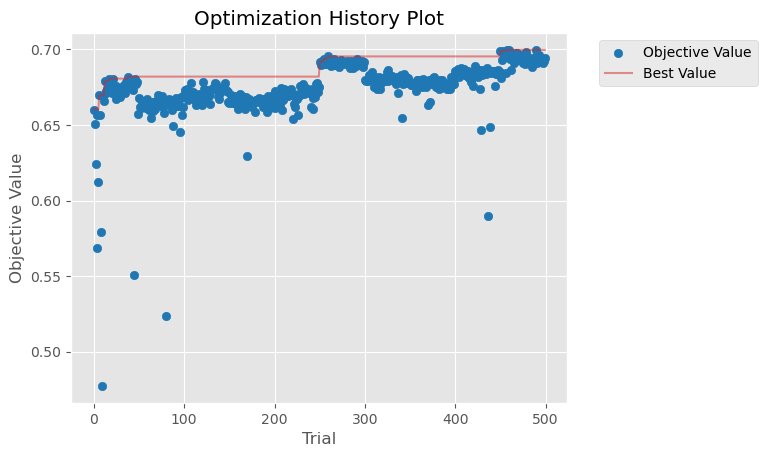

In [64]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

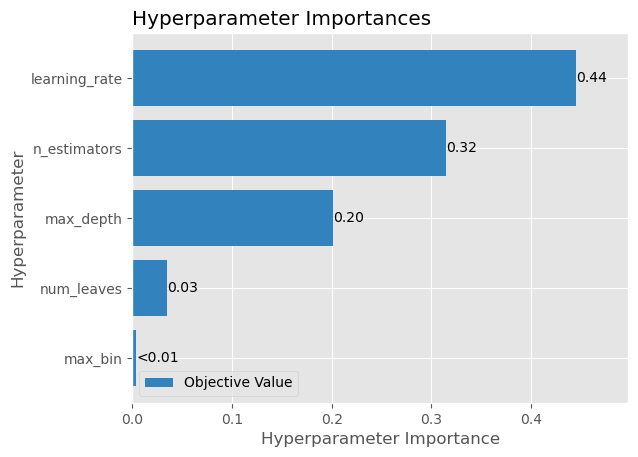

In [65]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [66]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.703916     0.017752
1                    TP       196.900000     7.489993
2                    TN       175.300000     5.888784
3                    FP        37.800000     2.699794
4                    FN        39.200000     5.138093
5              Accuracy         0.828582     0.011190
6             Precision         0.838772     0.013335
7           Sensitivity         0.834034     0.020667
8           Specificity         0.822730     0.009237
9              F1 score         0.836254     0.012988
10  F1 score (weighted)         0.828623     0.011130
11     F1 score (macro)         0.828071     0.011107
12    Balanced Accuracy         0.828375     0.010894
13                  MCC         0.656472     0.022261
14                  NPV         0.817440     0.021849
15              ROC_AUC         0.828375     0.010894


In [67]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.682897,0.713345,0.691267,0.702469,0.689476,0.671779,0.691702,0.681573,0.697324,0.677127,0.689896,0.012374
1,TP,396.000000,399.000000,365.000000,396.000000,400.000000,387.000000,404.000000,402.000000,400.000000,385.000000,393.400000,11.720827
2,TN,341.000000,341.000000,360.000000,355.000000,347.000000,359.000000,344.000000,340.000000,344.000000,346.000000,347.700000,7.543209
3,FP,85.000000,81.000000,92.000000,65.000000,76.000000,79.000000,85.000000,73.000000,82.000000,97.000000,81.500000,9.168182
4,FN,77.000000,78.000000,82.000000,83.000000,76.000000,74.000000,66.000000,84.000000,73.000000,71.000000,76.400000,5.680376
5,Accuracy,0.819800,0.823137,0.806452,0.835373,0.830923,0.829811,0.832036,0.825362,0.827586,0.813126,0.824360,0.009028
6,Precision,0.823285,0.831250,0.798687,0.859002,0.840336,0.830472,0.826176,0.846316,0.829876,0.798755,0.828415,0.018878
7,Sensitivity,0.837209,0.836478,0.816555,0.826722,0.840336,0.839479,0.859574,0.827160,0.845666,0.844298,0.837348,0.011901
8,Specificity,0.800500,0.808100,0.796500,0.845200,0.820300,0.819600,0.801900,0.823200,0.807500,0.781000,0.810380,0.017635
9,F1 score,0.830189,0.833856,0.807522,0.842553,0.840336,0.834951,0.842544,0.836629,0.837696,0.820896,0.832717,0.010948


In [68]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,CHEMBL3921050,0,6.17,5.726472,5.632965,5.734820,5.654171,5.775805,5.782372,0.180020
1,CHEMBL270476,1,6.80,6.771562,6.751000,6.578990,6.491464,6.731084,6.687350,0.112442
2,CHEMBL3664128,2,7.62,6.877704,7.088313,7.232468,7.116716,7.187726,7.187154,0.223569
3,CHEMBL4456250,3,5.26,5.826164,6.104230,6.005490,6.067481,5.948684,5.868675,0.286479
4,CHEMBL2408818,4,6.32,6.328565,6.105591,6.304581,6.214122,6.144022,6.236147,0.087819
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4250302,4487,10.25,9.175185,9.235402,8.946572,9.674591,9.377685,9.443239,0.422376
4488,CHEMBL483893,4488,7.83,7.954971,7.801202,7.716017,7.818377,7.769491,7.815009,0.072901
4489,CHEMBL3655914,4489,6.69,6.485789,6.523522,6.690245,6.561860,6.600607,6.592004,0.077684
4490,CHEMBL467876,4490,7.40,7.367752,7.201621,7.246571,7.417990,7.354891,7.331471,0.079703


In [69]:
mat_met_optimized_lgbm

,Metric,Value (average),Value (std)
0,R2,0.702511,0.024708
1,Accuracy,0.829963,0.016795
2,Precision,0.841218,0.023278
3,Sensitivity,0.834114,0.026497
4,Specificity,0.825432,0.026409
5,F1 score,0.837296,0.017856
6,F1 score (weighted),0.829968,0.016788
7,F1 score (macro),0.829349,0.016755
8,Balanced Accuracy,0.829772,0.016725
9,MCC,0.659510,0.033481


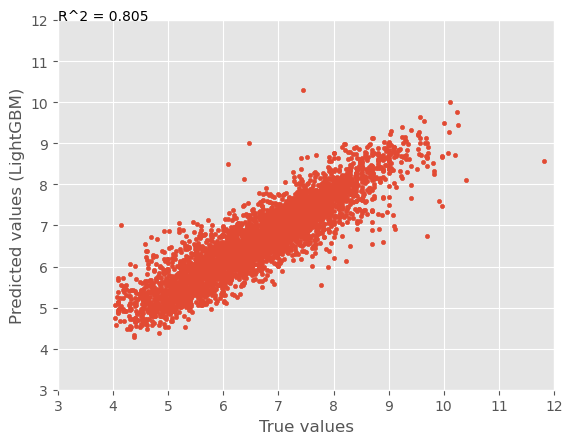

In [70]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (3, 12))
plt.show()

In [71]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.6713 with a standard deviation of 0.0188
LightGBM optimized model r2_score 0.7067 with a standard deviation of 0.0198


In [72]:
joblib.dump(lgbm_reg, "OUTPUT/lgbm_reg.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm.joblib") 


['OUTPUT/optimizedCV_lgbm.joblib']

## XGBoost

In [73]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.656270     0.028237
1                    TP       193.300000     7.528465
2                    TN       171.000000     8.705043
3                    FP        42.100000     6.026792
4                    FN        42.800000     3.994441
5              Accuracy         0.810997     0.016811
6             Precision         0.821356     0.023250
7           Sensitivity         0.818689     0.016089
8           Specificity         0.802400     0.027562
9              F1 score         0.819863     0.015956
10  F1 score (weighted)         0.810998     0.016848
11     F1 score (macro)         0.810351     0.016872
12    Balanced Accuracy         0.810546     0.017039
13                  MCC         0.621054     0.033807
14                  NPV         0.799650     0.018890
15              ROC_AUC         0.810546     0.017039
CPU times: user 2h 5min 54s, sys: 8.15 s, total: 2h 6min 2s
Wall time: 6min 54s


In [74]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [75]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [76]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 01:06:16,109] A new study created in memory with name: XGBRegressor
[I 2023-12-20 01:06:36,142] Trial 0 finished with value: 0.6803221030245348 and parameters: {'n_estimators': 503, 'eta': 0.07343108108415618, 'max_depth': 10, 'alpha': 0.9039, 'lambda': 17.3866904875639, 'max_bin': 436}. Best is trial 0 with value: 0.6803221030245348.
[I 2023-12-20 01:06:45,701] Trial 1 finished with value: 0.6672363717423804 and parameters: {'n_estimators': 375, 'eta': 0.08819308254605975, 'max_depth': 7, 'alpha': 0.6915, 'lambda': 1.368252527236697, 'max_bin': 281}. Best is trial 0 with value: 0.6803221030245348.
[I 2023-12-20 01:07:14,766] Trial 2 finished with value: 0.6130601160679923 and parameters: {'n_estimators': 781, 'eta': 0.006575299427652851, 'max_depth': 9, 'alpha': 0.2223, 'lambda': 9.097592367958981, 'max_bin': 358}. Best is trial 0 with value: 0.6803221030245348.
[I 2023-12-20 01:07:29,569] Trial 3 finished with value: 0.6797737360652987 and parameters: {'n_estimators': 5

	Number of trials: 50.0
	Best value (r2_score): 0.6841
	Best params:
		n_estimators: 863
		eta: 0.04049106965479992
		max_depth: 11
		alpha: 0.2132
		lambda: 23.71448227647675
		max_bin: 441


In [77]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
y_pred_xgb_0_cat = np.where((y_pred_xgb_0 >= 6.6), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.696313
1                    TP  401.000000
2                    TN  350.000000
3                    FP   76.000000
4                    FN   72.000000
5              Accuracy    0.835373
6             Precision    0.840671
7           Sensitivity    0.847780
8           Specificity    0.821600
9              F1 score    0.844211
10  F1 score (weighted)    0.835331
11     F1 score (macro)    0.834841
12    Balanced Accuracy    0.834688
13                  MCC    0.669715
14                  NPV    0.829400
15              ROC_AUC    0.834688


In [78]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 01:29:33,215] Trial 50 finished with value: 0.6774787370346338 and parameters: {'n_estimators': 873, 'eta': 0.03545715373766487, 'max_depth': 10, 'alpha': 0.444, 'lambda': 20.462630079096844, 'max_bin': 495}. Best is trial 40 with value: 0.6840639006627747.
[I 2023-12-20 01:29:35,041] Trial 51 finished with value: 0.13643817548010848 and parameters: {'n_estimators': 57, 'eta': 0.04392110972781907, 'max_depth': 11, 'alpha': 0.5729000000000001, 'lambda': 22.208057177611668, 'max_bin': 490}. Best is trial 40 with value: 0.6840639006627747.
[I 2023-12-20 01:30:10,027] Trial 52 finished with value: 0.6759205036866187 and parameters: {'n_estimators': 778, 'eta': 0.02768647321810188, 'max_depth': 10, 'alpha': 0.3245, 'lambda': 15.62441025981625, 'max_bin': 481}. Best is trial 40 with value: 0.6840639006627747.
[I 2023-12-20 01:30:45,089] Trial 53 finished with value: 0.677087080045697 and parameters: {'n_estimators': 807, 'eta': 0.05029512373642307, 'max_depth': 11, 'alpha': 0.8

	Number of trials: 100.0
	Best value (r2_score): 0.6841
	Best params:
		n_estimators: 863
		eta: 0.04049106965479992
		max_depth: 11
		alpha: 0.2132
		lambda: 23.71448227647675
		max_bin: 441


In [79]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_1_cat = np.where((y_pred_xgb_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.696313    0.701416
1                    TP  401.000000  403.000000
2                    TN  350.000000  338.000000
3                    FP   76.000000   84.000000
4                    FN   72.000000   74.000000
5              Accuracy    0.835373    0.824249
6             Precision    0.840671    0.827515
7           Sensitivity    0.847780    0.844864
8           Specificity    0.821600    0.800900
9              F1 score    0.844211    0.836100
10  F1 score (weighted)    0.835331    0.824107
11     F1 score (macro)    0.834841    0.823326
12    Balanced Accuracy    0.834688    0.822906
13                  MCC    0.669715    0.646857
14                  NPV    0.829400    0.820400
15              ROC_AUC    0.834688    0.822906


In [80]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 01:57:35,282] Trial 100 finished with value: 0.6855349795455682 and parameters: {'n_estimators': 885, 'eta': 0.03569250329675222, 'max_depth': 12, 'alpha': 0.9468000000000001, 'lambda': 22.45991768300684, 'max_bin': 393}. Best is trial 100 with value: 0.6855349795455682.
[I 2023-12-20 01:58:20,584] Trial 101 finished with value: 0.6845586573462541 and parameters: {'n_estimators': 886, 'eta': 0.033710308869760015, 'max_depth': 12, 'alpha': 0.8669, 'lambda': 22.319655762587413, 'max_bin': 393}. Best is trial 100 with value: 0.6855349795455682.
[I 2023-12-20 01:59:05,734] Trial 102 finished with value: 0.6827618595522782 and parameters: {'n_estimators': 885, 'eta': 0.033877525230696044, 'max_depth': 12, 'alpha': 0.6127, 'lambda': 22.25076630864379, 'max_bin': 395}. Best is trial 100 with value: 0.6855349795455682.
[I 2023-12-20 01:59:49,278] Trial 103 finished with value: 0.6854285760407307 and parameters: {'n_estimators': 884, 'eta': 0.03384607387578621, 'max_depth': 12, 'a

	Number of trials: 150.0
	Best value (r2_score): 0.6883
	Best params:
		n_estimators: 854
		eta: 0.03904978341331239
		max_depth: 12
		alpha: 0.9987
		lambda: 15.500449545987768
		max_bin: 396


In [81]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_2_cat = np.where((y_pred_xgb_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.696313    0.701416    0.713121
1                    TP  401.000000  403.000000  373.000000
2                    TN  350.000000  338.000000  372.000000
3                    FP   76.000000   84.000000   80.000000
4                    FN   72.000000   74.000000   74.000000
5              Accuracy    0.835373    0.824249    0.828699
6             Precision    0.840671    0.827515    0.823400
7           Sensitivity    0.847780    0.844864    0.834452
8           Specificity    0.821600    0.800900    0.823000
9              F1 score    0.844211    0.836100    0.828889
10  F1 score (weighted)    0.835331    0.824107    0.828697
11     F1 score (macro)    0.834841    0.823326    0.828698
12    Balanced Accuracy    0.834688    0.822906    0.828730
13                  MCC    0.669715    0.646857    0.657471
14                  NPV    0.829400    0.820400    0.834100
15              ROC_AUC    0.834688    0

In [82]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 02:28:39,360] Trial 150 finished with value: 0.6814516435107054 and parameters: {'n_estimators': 872, 'eta': 0.043961001448516654, 'max_depth': 12, 'alpha': 0.8313, 'lambda': 17.105633495783476, 'max_bin': 379}. Best is trial 142 with value: 0.6882679854207645.
[I 2023-12-20 02:29:12,507] Trial 151 finished with value: 0.6794873967210816 and parameters: {'n_estimators': 852, 'eta': 0.04198618637452359, 'max_depth': 12, 'alpha': 0.8654000000000001, 'lambda': 18.691019309881764, 'max_bin': 371}. Best is trial 142 with value: 0.6882679854207645.
[I 2023-12-20 02:29:47,788] Trial 152 finished with value: 0.6794471505158292 and parameters: {'n_estimators': 875, 'eta': 0.03968023286574057, 'max_depth': 12, 'alpha': 0.9793000000000001, 'lambda': 17.661091810757792, 'max_bin': 386}. Best is trial 142 with value: 0.6882679854207645.
[I 2023-12-20 02:30:18,786] Trial 153 finished with value: 0.6792961505428569 and parameters: {'n_estimators': 822, 'eta': 0.04936107447812272, 'max_d

	Number of trials: 200.0
	Best value (r2_score): 0.6883
	Best params:
		n_estimators: 854
		eta: 0.03904978341331239
		max_depth: 12
		alpha: 0.9987
		lambda: 15.500449545987768
		max_bin: 396


In [83]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_3_cat = np.where((y_pred_xgb_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.696313    0.701416    0.713121    0.730474
1                    TP  401.000000  403.000000  373.000000  410.000000
2                    TN  350.000000  338.000000  372.000000  349.000000
3                    FP   76.000000   84.000000   80.000000   71.000000
4                    FN   72.000000   74.000000   74.000000   69.000000
5              Accuracy    0.835373    0.824249    0.828699    0.844271
6             Precision    0.840671    0.827515    0.823400    0.852391
7           Sensitivity    0.847780    0.844864    0.834452    0.855950
8           Specificity    0.821600    0.800900    0.823000    0.831000
9              F1 score    0.844211    0.836100    0.828889    0.854167
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551
12    Balanced Accuracy    0.834688    0.822906    0.828730    0

In [84]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 02:59:01,351] Trial 200 finished with value: 0.6822061068548834 and parameters: {'n_estimators': 835, 'eta': 0.042631285168769545, 'max_depth': 12, 'alpha': 0.9772000000000001, 'lambda': 18.94932100863378, 'max_bin': 403}. Best is trial 142 with value: 0.6882679854207645.
[I 2023-12-20 02:59:47,256] Trial 201 finished with value: 0.6833164248383599 and parameters: {'n_estimators': 892, 'eta': 0.037192197089989054, 'max_depth': 12, 'alpha': 0.9143, 'lambda': 19.808772209924356, 'max_bin': 401}. Best is trial 142 with value: 0.6882679854207645.
[I 2023-12-20 03:00:29,101] Trial 202 finished with value: 0.682138920798429 and parameters: {'n_estimators': 899, 'eta': 0.03636865267419925, 'max_depth': 12, 'alpha': 0.8230000000000001, 'lambda': 19.21477460460253, 'max_bin': 392}. Best is trial 142 with value: 0.6882679854207645.
[I 2023-12-20 03:01:09,819] Trial 203 finished with value: 0.6805074084679033 and parameters: {'n_estimators': 873, 'eta': 0.03981340727188514, 'max_dep

	Number of trials: 250.0
	Best value (r2_score): 0.6883
	Best params:
		n_estimators: 854
		eta: 0.03904978341331239
		max_depth: 12
		alpha: 0.9987
		lambda: 15.500449545987768
		max_bin: 396


In [85]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_4_cat = np.where((y_pred_xgb_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.696313    0.701416    0.713121    0.730474   
1                    TP  401.000000  403.000000  373.000000  410.000000   
2                    TN  350.000000  338.000000  372.000000  349.000000   
3                    FP   76.000000   84.000000   80.000000   71.000000   
4                    FN   72.000000   74.000000   74.000000   69.000000   
5              Accuracy    0.835373    0.824249    0.828699    0.844271   
6             Precision    0.840671    0.827515    0.823400    0.852391   
7           Sensitivity    0.847780    0.844864    0.834452    0.855950   
8           Specificity    0.821600    0.800900    0.823000    0.831000   
9              F1 score    0.844211    0.836100    0.828889    0.854167   
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248   
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551   
12    Balanced Accuracy  

In [86]:
len(y_pred_xgb_4_cat)

899

In [87]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 03:28:15,654] Trial 250 finished with value: 0.7035474082433079 and parameters: {'n_estimators': 871, 'eta': 0.04227685651475006, 'max_depth': 12, 'alpha': 0.9428000000000001, 'lambda': 17.08604578987236, 'max_bin': 378}. Best is trial 250 with value: 0.7035474082433079.
[I 2023-12-20 03:28:58,579] Trial 251 finished with value: 0.7005489317141368 and parameters: {'n_estimators': 885, 'eta': 0.04401005123937145, 'max_depth': 12, 'alpha': 0.9576, 'lambda': 16.1749063196018, 'max_bin': 378}. Best is trial 250 with value: 0.7035474082433079.
[I 2023-12-20 03:29:37,639] Trial 252 finished with value: 0.7011520100172944 and parameters: {'n_estimators': 900, 'eta': 0.044738222517564305, 'max_depth': 12, 'alpha': 0.9656, 'lambda': 16.94570192661109, 'max_bin': 378}. Best is trial 250 with value: 0.7035474082433079.
[I 2023-12-20 03:30:18,756] Trial 253 finished with value: 0.7022190863803869 and parameters: {'n_estimators': 898, 'eta': 0.04690023212437378, 'max_depth': 12, 'alph

	Number of trials: 300.0
	Best value (r2_score): 0.7086
	Best params:
		n_estimators: 900
		eta: 0.052282964474475044
		max_depth: 9
		alpha: 0.9758
		lambda: 15.852769374672869
		max_bin: 372


In [88]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5

y_pred_xgb_5_cat = np.where((y_pred_xgb_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.696313    0.701416    0.713121    0.730474   
1                    TP  401.000000  403.000000  373.000000  410.000000   
2                    TN  350.000000  338.000000  372.000000  349.000000   
3                    FP   76.000000   84.000000   80.000000   71.000000   
4                    FN   72.000000   74.000000   74.000000   69.000000   
5              Accuracy    0.835373    0.824249    0.828699    0.844271   
6             Precision    0.840671    0.827515    0.823400    0.852391   
7           Sensitivity    0.847780    0.844864    0.834452    0.855950   
8           Specificity    0.821600    0.800900    0.823000    0.831000   
9              F1 score    0.844211    0.836100    0.828889    0.854167   
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248   
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551   
12    Balanced Accuracy  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 03:56:09,888] Trial 300 finished with value: 0.6964157803650338 and parameters: {'n_estimators': 880, 'eta': 0.05849074938569992, 'max_depth': 9, 'alpha': 0.9799, 'lambda': 13.49495924081242, 'max_bin': 320}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 03:56:37,710] Trial 301 finished with value: 0.6946243805373635 and parameters: {'n_estimators': 879, 'eta': 0.057358636779914596, 'max_depth': 9, 'alpha': 0.9816, 'lambda': 13.263879357366129, 'max_bin': 349}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 03:57:06,640] Trial 302 finished with value: 0.6978761679954149 and parameters: {'n_estimators': 881, 'eta': 0.0562587841800666, 'max_depth': 9, 'alpha': 0.9997, 'lambda': 12.926803030222324, 'max_bin': 337}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 03:57:40,275] Trial 303 finished with value: 0.6936909548698028 and parameters: {'n_estimators': 875, 'eta': 0.055131383979434755, 'max_depth': 9, 'alpha': 0.9770000

	Number of trials: 350.0
	Best value (r2_score): 0.7086
	Best params:
		n_estimators: 900
		eta: 0.052282964474475044
		max_depth: 9
		alpha: 0.9758
		lambda: 15.852769374672869
		max_bin: 372


In [90]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_6_cat = np.where((y_pred_xgb_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.696313    0.701416    0.713121    0.730474   
1                    TP  401.000000  403.000000  373.000000  410.000000   
2                    TN  350.000000  338.000000  372.000000  349.000000   
3                    FP   76.000000   84.000000   80.000000   71.000000   
4                    FN   72.000000   74.000000   74.000000   69.000000   
5              Accuracy    0.835373    0.824249    0.828699    0.844271   
6             Precision    0.840671    0.827515    0.823400    0.852391   
7           Sensitivity    0.847780    0.844864    0.834452    0.855950   
8           Specificity    0.821600    0.800900    0.823000    0.831000   
9              F1 score    0.844211    0.836100    0.828889    0.854167   
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248   
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551   
12    Balanced Accuracy  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 04:19:25,360] Trial 350 finished with value: 0.6271874577156036 and parameters: {'n_estimators': 143, 'eta': 0.05594835932986052, 'max_depth': 9, 'alpha': 0.9999, 'lambda': 33.522789520882284, 'max_bin': 338}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 04:19:55,665] Trial 351 finished with value: 0.6904402703066299 and parameters: {'n_estimators': 885, 'eta': 0.049209037878264666, 'max_depth': 9, 'alpha': 0.9807, 'lambda': 32.33928989445726, 'max_bin': 352}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 04:20:09,408] Trial 352 finished with value: 0.682341478074002 and parameters: {'n_estimators': 362, 'eta': 0.05863783346811289, 'max_depth': 9, 'alpha': 0.9413, 'lambda': 15.11798548888299, 'max_bin': 356}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 04:20:40,691] Trial 353 finished with value: 0.6905686029742617 and parameters: {'n_estimators': 867, 'eta': 0.05091649099125072, 'max_depth': 10, 'alpha': 0.9805, 'l

	Number of trials: 400.0
	Best value (r2_score): 0.7086
	Best params:
		n_estimators: 900
		eta: 0.052282964474475044
		max_depth: 9
		alpha: 0.9758
		lambda: 15.852769374672869
		max_bin: 372


In [92]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
y_pred_xgb_7_cat = np.where((y_pred_xgb_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.696313    0.701416    0.713121    0.730474   
1                    TP  401.000000  403.000000  373.000000  410.000000   
2                    TN  350.000000  338.000000  372.000000  349.000000   
3                    FP   76.000000   84.000000   80.000000   71.000000   
4                    FN   72.000000   74.000000   74.000000   69.000000   
5              Accuracy    0.835373    0.824249    0.828699    0.844271   
6             Precision    0.840671    0.827515    0.823400    0.852391   
7           Sensitivity    0.847780    0.844864    0.834452    0.855950   
8           Specificity    0.821600    0.800900    0.823000    0.831000   
9              F1 score    0.844211    0.836100    0.828889    0.854167   
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248   
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 04:41:55,751] Trial 400 finished with value: 0.6966745406277391 and parameters: {'n_estimators': 872, 'eta': 0.05333256242953155, 'max_depth': 9, 'alpha': 0.9505, 'lambda': 16.31796327738855, 'max_bin': 330}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 04:42:22,184] Trial 401 finished with value: 0.695230625445403 and parameters: {'n_estimators': 900, 'eta': 0.05882474803571046, 'max_depth': 8, 'alpha': 0.9824, 'lambda': 13.787997377635326, 'max_bin': 368}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 04:42:52,758] Trial 402 finished with value: 0.6940845894109678 and parameters: {'n_estimators': 862, 'eta': 0.04982573757944718, 'max_depth': 9, 'alpha': 0.9997, 'lambda': 14.472494615472788, 'max_bin': 359}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 04:43:22,515] Trial 403 finished with value: 0.692684475615012 and parameters: {'n_estimators': 884, 'eta': 0.05481253271468826, 'max_depth': 9, 'alpha': 0.9685, 'lam

	Number of trials: 450.0
	Best value (r2_score): 0.7086
	Best params:
		n_estimators: 900
		eta: 0.052282964474475044
		max_depth: 9
		alpha: 0.9758
		lambda: 15.852769374672869
		max_bin: 372


In [94]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
y_pred_xgb_8_cat = np.where((y_pred_xgb_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.696313    0.701416    0.713121    0.730474   
1                    TP  401.000000  403.000000  373.000000  410.000000   
2                    TN  350.000000  338.000000  372.000000  349.000000   
3                    FP   76.000000   84.000000   80.000000   71.000000   
4                    FN   72.000000   74.000000   74.000000   69.000000   
5              Accuracy    0.835373    0.824249    0.828699    0.844271   
6             Precision    0.840671    0.827515    0.823400    0.852391   
7           Sensitivity    0.847780    0.844864    0.834452    0.855950   
8           Specificity    0.821600    0.800900    0.823000    0.831000   
9              F1 score    0.844211    0.836100    0.828889    0.854167   
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248   
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551   
12    Balanced Accuracy  

In [95]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:05:25,588] Trial 450 finished with value: 0.7033381784792011 and parameters: {'n_estimators': 871, 'eta': 0.08833516610652922, 'max_depth': 9, 'alpha': 0.9632000000000001, 'lambda': 13.679157115195201, 'max_bin': 343}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 05:05:58,290] Trial 451 finished with value: 0.7061928675981912 and parameters: {'n_estimators': 887, 'eta': 0.05420986883205453, 'max_depth': 9, 'alpha': 0.9812000000000001, 'lambda': 17.871614973020996, 'max_bin': 332}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 05:06:31,082] Trial 452 finished with value: 0.7072021059682347 and parameters: {'n_estimators': 852, 'eta': 0.04786790057441577, 'max_depth': 9, 'alpha': 0.9217000000000001, 'lambda': 18.216898270642535, 'max_bin': 324}. Best is trial 263 with value: 0.7085707603331093.
[I 2023-12-20 05:07:08,212] Trial 453 finished with value: 0.7052367897842972 and parameters: {'n_estimators': 847, 'eta': 0.04704298727147782

	Number of trials: 500.0
	Best value (r2_score): 0.7086
	Best params:
		n_estimators: 900
		eta: 0.052282964474475044
		max_depth: 9
		alpha: 0.9758
		lambda: 15.852769374672869
		max_bin: 372


In [96]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_9_cat = np.where((y_pred_xgb_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.696313    0.701416    0.713121    0.730474   
1                    TP  401.000000  403.000000  373.000000  410.000000   
2                    TN  350.000000  338.000000  372.000000  349.000000   
3                    FP   76.000000   84.000000   80.000000   71.000000   
4                    FN   72.000000   74.000000   74.000000   69.000000   
5              Accuracy    0.835373    0.824249    0.828699    0.844271   
6             Precision    0.840671    0.827515    0.823400    0.852391   
7           Sensitivity    0.847780    0.844864    0.834452    0.855950   
8           Specificity    0.821600    0.800900    0.823000    0.831000   
9              F1 score    0.844211    0.836100    0.828889    0.854167   
10  F1 score (weighted)    0.835331    0.824107    0.828697    0.844248   
11     F1 score (macro)    0.834841    0.823326    0.828698    0.843551   
12    Balanced Accuracy  

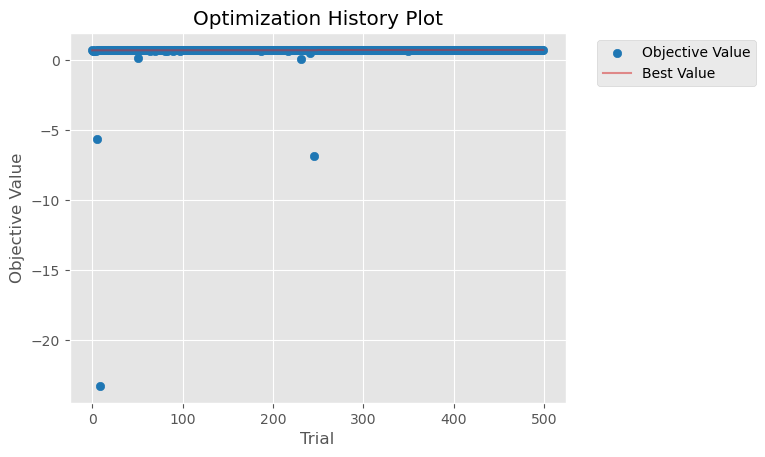

In [97]:
plot_optimization_history(study_xgb);

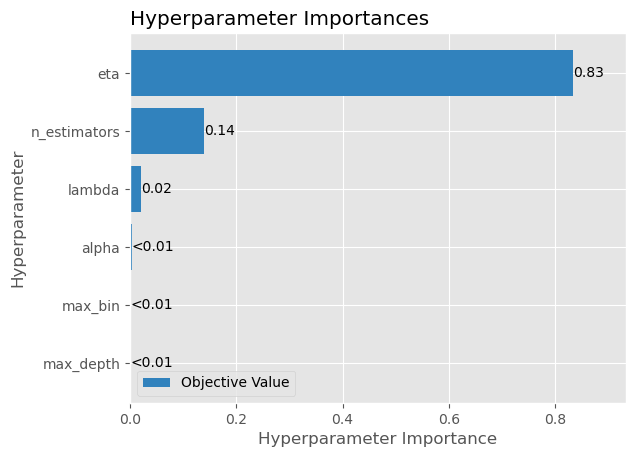

In [98]:
plot_param_importances(study_xgb);

In [99]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.714360,0.024500
1,TP,202.400000,7.618690
2,TN,174.600000,6.785606
3,FP,38.500000,4.403282
4,FN,33.700000,5.396501
5,Accuracy,0.839268,0.008917
6,Precision,0.840300,0.015852
7,Sensitivity,0.857352,0.021985
8,Specificity,0.819440,0.018382
9,F1 score,0.848467,0.010424


In [100]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.696313,0.701416,0.713121,0.730474,0.712344,0.692140,0.695690,0.699110,0.701671,0.674841,0.701712,0.014744
1,TP,401.000000,403.000000,373.000000,410.000000,411.000000,388.000000,402.000000,426.000000,407.000000,396.000000,401.700000,14.220877
2,TN,350.000000,338.000000,372.000000,349.000000,344.000000,366.000000,345.000000,339.000000,338.000000,340.000000,348.100000,11.901914
3,FP,76.000000,84.000000,80.000000,71.000000,79.000000,72.000000,84.000000,74.000000,88.000000,103.000000,81.100000,9.492102
4,FN,72.000000,74.000000,74.000000,69.000000,65.000000,73.000000,68.000000,60.000000,66.000000,60.000000,68.100000,5.321863
5,Accuracy,0.835373,0.824249,0.828699,0.844271,0.839822,0.838710,0.830923,0.850945,0.828699,0.818687,0.834038,0.009694
6,Precision,0.840671,0.827515,0.823400,0.852391,0.838776,0.843478,0.827160,0.852000,0.822222,0.793587,0.832120,0.017503
7,Sensitivity,0.847780,0.844864,0.834452,0.855950,0.863445,0.841649,0.855319,0.876543,0.860465,0.868421,0.854889,0.012917
8,Specificity,0.821600,0.800900,0.823000,0.831000,0.813200,0.835600,0.804200,0.820800,0.793400,0.767500,0.811120,0.020310
9,F1 score,0.844211,0.836100,0.828889,0.854167,0.850932,0.842562,0.841004,0.864097,0.840909,0.829319,0.843219,0.010935


In [101]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5

random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id, xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,CHEMBL3921050,0,6.17,5.715065,5.710178,5.713224,5.744065,5.650393,5.783821,0.174953
1,CHEMBL270476,1,6.80,6.779842,6.810263,6.766532,6.821313,6.652802,6.771792,0.056242
2,CHEMBL3664128,2,7.62,7.129533,7.077412,7.113159,7.443276,7.137381,7.253460,0.204080
3,CHEMBL4456250,3,5.26,5.845671,6.146075,5.704451,5.991127,5.541411,5.748122,0.291500
4,CHEMBL2408818,4,6.32,6.046592,6.088707,6.207484,6.108141,5.992596,6.127253,0.108073
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4250302,4487,10.25,9.153563,9.422625,9.378964,9.293154,9.494086,9.498732,0.352601
4488,CHEMBL483893,4488,7.83,7.621792,7.651759,7.516408,7.731095,7.819549,7.695100,0.111179
4489,CHEMBL3655914,4489,6.69,6.644430,6.719728,6.684826,6.609362,6.621881,6.661705,0.039425
4490,CHEMBL467876,4490,7.40,7.337439,7.231032,7.286335,7.270732,7.203191,7.288122,0.065481


In [102]:
mat_met_optimized_xgb

,Metric,Value (average),Value (std)
0,R2,0.712577,0.023918
1,Accuracy,0.836689,0.015774
2,Precision,0.840652,0.022426
3,Sensitivity,0.850831,0.024673
4,Specificity,0.821040,0.026468
5,F1 score,0.845376,0.016258
6,F1 score (weighted),0.836600,0.015762
7,F1 score (macro),0.835903,0.015788
8,Balanced Accuracy,0.835935,0.015745
9,MCC,0.672629,0.031665


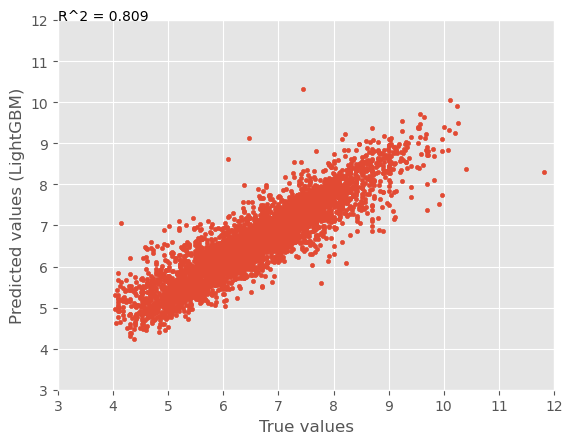

In [103]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (3, 12))
plt.show()

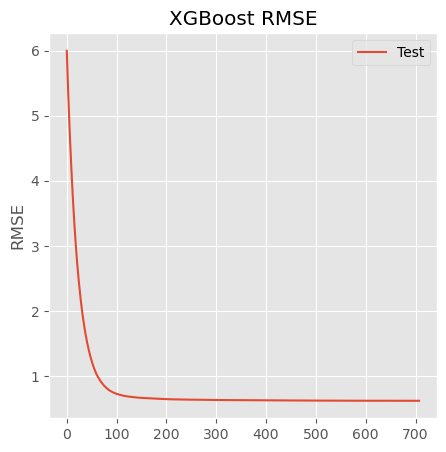

In [104]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [105]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.6569 with a standard deviation of 0.0236
XGBoost optimized model r2_score 0.7120 with a standard deviation of 0.0210


In [106]:
joblib.dump(xgb_reg, "OUTPUT/xgb_reg.joblib")
joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb.joblib")

['OUTPUT/optimizedCV_xgb.joblib']

## KNeighbors (KNN)

In [107]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.649669     0.027233
1                    TP       193.900000     6.999206
2                    TN       170.400000     8.921883
3                    FP        42.700000     3.888730
4                    FN        42.200000     6.795423
5              Accuracy         0.810993     0.014677
6             Precision         0.819698     0.012074
7           Sensitivity         0.821538     0.026219
8           Specificity         0.799330     0.020868
9              F1 score         0.820355     0.013351
10  F1 score (weighted)         0.810960     0.014626
11     F1 score (macro)         0.810273     0.015021
12    Balanced Accuracy         0.810431     0.014821
13                  MCC         0.621124     0.030010
14                  NPV         0.801690     0.029070
15              ROC_AUC         0.810431     0.014821
CPU times: user 5.05 s, sys: 12.4 s, total: 17.4 s
Wall time: 757 ms


In [108]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [109]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [110]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:44:17,979] A new study created in memory with name: KNNregressor
[I 2023-12-20 05:44:20,269] Trial 0 finished with value: 0.6289826848833393 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 33}. Best is trial 0 with value: 0.6289826848833393.
[I 2023-12-20 05:44:22,360] Trial 1 finished with value: 0.6355712732730321 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 68}. Best is trial 1 with value: 0.6355712732730321.
[I 2023-12-20 05:44:24,607] Trial 2 finished with value: 0.5475692374892493 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 24}. Best is trial 1 with value: 0.6355712732730321.
[I 2023-12-20 05:44:26,936] Trial 3 finished with value: 0.5508250840738482 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 60}. Best is trial 1 with value: 0.6355712732730321.
[I 2023-12-20 05:44:28,798]

	Number of trials: 50.0
	Best value (r2_score): 0.6466
	Best params:
		n_neighbors: 8
		weights: distance
		metric: manhattan
		leaf_size: 83


In [111]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
y_pred_knn_0_cat = np.where((y_pred_knn_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.635546
1                    TP  373.000000
2                    TN  341.000000
3                    FP   85.000000
4                    FN  100.000000
5              Accuracy    0.794216
6             Precision    0.814410
7           Sensitivity    0.788584
8           Specificity    0.800500
9              F1 score    0.801289
10  F1 score (weighted)    0.794338
11     F1 score (macro)    0.793955
12    Balanced Accuracy    0.794526
13                  MCC    0.588353
14                  NPV    0.773200
15              ROC_AUC    0.794526


In [112]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:45:35,599] Trial 50 finished with value: 0.6302558896832988 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:45:36,376] Trial 51 finished with value: 0.6319357125401476 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:45:37,123] Trial 52 finished with value: 0.6327958919332486 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 89}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:45:38,027] Trial 53 finished with value: 0.6345259794347854 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:45:38,964] Trial 54 finished with value: 0.6319357125401476 and parameters: {'n_n

	Number of trials: 100.0
	Best value (r2_score): 0.6466
	Best params:
		n_neighbors: 8
		weights: distance
		metric: manhattan
		leaf_size: 83


In [113]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
y_pred_knn_1_cat = np.where((y_pred_knn_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.635546    0.641951
1                    TP  373.000000  388.000000
2                    TN  341.000000  325.000000
3                    FP   85.000000   97.000000
4                    FN  100.000000   89.000000
5              Accuracy    0.794216    0.793103
6             Precision    0.814410    0.800000
7           Sensitivity    0.788584    0.813417
8           Specificity    0.800500    0.770100
9              F1 score    0.801289    0.806653
10  F1 score (weighted)    0.794338    0.792974
11     F1 score (macro)    0.793955    0.792082
12    Balanced Accuracy    0.794526    0.791780
13                  MCC    0.588353    0.584291
14                  NPV    0.773200    0.785000
15              ROC_AUC    0.794526    0.791780


In [114]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:46:30,573] Trial 100 finished with value: 0.6321896626638315 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 79}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:46:32,819] Trial 101 finished with value: 0.6132379031791084 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 66}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:46:34,598] Trial 102 finished with value: 0.6070460004580231 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 86}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:46:35,916] Trial 103 finished with value: 0.6121925053680879 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 91}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:46:38,213] Trial 104 finished with value: 0.6132379031791084 and parameters: {'n_n

	Number of trials: 150.0
	Best value (r2_score): 0.6466
	Best params:
		n_neighbors: 8
		weights: distance
		metric: manhattan
		leaf_size: 83


In [115]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
y_pred_knn_2_cat = np.where((y_pred_knn_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.635546    0.641951    0.676110
1                    TP  373.000000  388.000000  369.000000
2                    TN  341.000000  325.000000  358.000000
3                    FP   85.000000   97.000000   94.000000
4                    FN  100.000000   89.000000   78.000000
5              Accuracy    0.794216    0.793103    0.808676
6             Precision    0.814410    0.800000    0.796976
7           Sensitivity    0.788584    0.813417    0.825503
8           Specificity    0.800500    0.770100    0.792000
9              F1 score    0.801289    0.806653    0.810989
10  F1 score (weighted)    0.794338    0.792974    0.808635
11     F1 score (macro)    0.793955    0.792082    0.808648
12    Balanced Accuracy    0.794526    0.791780    0.808769
13                  MCC    0.588353    0.584291    0.617808
14                  NPV    0.773200    0.785000    0.821100
15              ROC_AUC    0.794526    0

In [116]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:47:56,096] Trial 150 finished with value: 0.6115972275656645 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:47:58,328] Trial 151 finished with value: 0.6298989191668013 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 89}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:48:00,792] Trial 152 finished with value: 0.6219562128124304 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 81}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:48:03,629] Trial 153 finished with value: 0.6298989191668013 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 75}. Best is trial 38 with value: 0.6465768494641717.
[I 2023-12-20 05:48:05,169] Trial 154 finished with value: 0.606989939914574 and parameters: {'n_nei

	Number of trials: 200.0
	Best value (r2_score): 0.6466
	Best params:
		n_neighbors: 8
		weights: distance
		metric: manhattan
		leaf_size: 83


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
y_pred_knn_3_cat = np.where((y_pred_knn_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.635546    0.641951    0.676110    0.681134
1                    TP  373.000000  388.000000  369.000000  401.000000
2                    TN  341.000000  325.000000  358.000000  350.000000
3                    FP   85.000000   97.000000   94.000000   70.000000
4                    FN  100.000000   89.000000   78.000000   78.000000
5              Accuracy    0.794216    0.793103    0.808676    0.835373
6             Precision    0.814410    0.800000    0.796976    0.851380
7           Sensitivity    0.788584    0.813417    0.825503    0.837161
8           Specificity    0.800500    0.770100    0.792000    0.833300
9              F1 score    0.801289    0.806653    0.810989    0.844211
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841
12    Balanced Accuracy    0.794526    0.791780    0.808769    0

In [118]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:49:14,594] Trial 200 finished with value: 0.6469465511004584 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 200 with value: 0.6469465511004584.
[I 2023-12-20 05:49:15,468] Trial 201 finished with value: 0.6469465511004584 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 200 with value: 0.6469465511004584.
[I 2023-12-20 05:49:16,264] Trial 202 finished with value: 0.6469465511004584 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 200 with value: 0.6469465511004584.
[I 2023-12-20 05:49:17,044] Trial 203 finished with value: 0.6461161500710887 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 200 with value: 0.6469465511004584.
[I 2023-12-20 05:49:17,903] Trial 204 finished with value: 0.6461161500710887 and parameter

	Number of trials: 250.0
	Best value (r2_score): 0.6469
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 97


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
y_pred_knn_4_cat = np.where((y_pred_knn_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.635546    0.641951    0.676110    0.681134   
1                    TP  373.000000  388.000000  369.000000  401.000000   
2                    TN  341.000000  325.000000  358.000000  350.000000   
3                    FP   85.000000   97.000000   94.000000   70.000000   
4                    FN  100.000000   89.000000   78.000000   78.000000   
5              Accuracy    0.794216    0.793103    0.808676    0.835373   
6             Precision    0.814410    0.800000    0.796976    0.851380   
7           Sensitivity    0.788584    0.813417    0.825503    0.837161   
8           Specificity    0.800500    0.770100    0.792000    0.833300   
9              F1 score    0.801289    0.806653    0.810989    0.844211   
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456   
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841   
12    Balanced Accuracy  

In [120]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:49:55,682] Trial 250 finished with value: 0.6566178244224047 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 250 with value: 0.6566178244224047.
[I 2023-12-20 05:49:56,565] Trial 251 finished with value: 0.6566178244224047 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 250 with value: 0.6566178244224047.
[I 2023-12-20 05:49:57,345] Trial 252 finished with value: 0.6566178244224047 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 250 with value: 0.6566178244224047.
[I 2023-12-20 05:49:58,061] Trial 253 finished with value: 0.6566178244224047 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 250 with value: 0.6566178244224047.
[I 2023-12-20 05:49:58,769] Trial 254 finished with value: 0.6566178244224047 and parameters

	Number of trials: 300.0
	Best value (r2_score): 0.6598
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 98


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
y_pred_knn_5_cat = np.where((y_pred_knn_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.635546    0.641951    0.676110    0.681134   
1                    TP  373.000000  388.000000  369.000000  401.000000   
2                    TN  341.000000  325.000000  358.000000  350.000000   
3                    FP   85.000000   97.000000   94.000000   70.000000   
4                    FN  100.000000   89.000000   78.000000   78.000000   
5              Accuracy    0.794216    0.793103    0.808676    0.835373   
6             Precision    0.814410    0.800000    0.796976    0.851380   
7           Sensitivity    0.788584    0.813417    0.825503    0.837161   
8           Specificity    0.800500    0.770100    0.792000    0.833300   
9              F1 score    0.801289    0.806653    0.810989    0.844211   
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456   
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841   
12    Balanced Accuracy  

In [122]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:51:23,405] Trial 300 finished with value: 0.6515715098374768 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:51:24,884] Trial 301 finished with value: 0.5680560338215636 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:51:26,382] Trial 302 finished with value: 0.6515715098374768 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:51:29,302] Trial 303 finished with value: 0.6515715098374768 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:51:30,677] Trial 304 finished with value: 0.6515715098374768 and paramet

	Number of trials: 350.0
	Best value (r2_score): 0.6598
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 98


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
y_pred_knn_6_cat = np.where((y_pred_knn_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.635546    0.641951    0.676110    0.681134   
1                    TP  373.000000  388.000000  369.000000  401.000000   
2                    TN  341.000000  325.000000  358.000000  350.000000   
3                    FP   85.000000   97.000000   94.000000   70.000000   
4                    FN  100.000000   89.000000   78.000000   78.000000   
5              Accuracy    0.794216    0.793103    0.808676    0.835373   
6             Precision    0.814410    0.800000    0.796976    0.851380   
7           Sensitivity    0.788584    0.813417    0.825503    0.837161   
8           Specificity    0.800500    0.770100    0.792000    0.833300   
9              F1 score    0.801289    0.806653    0.810989    0.844211   
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456   
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841   
12    Balanced Accuracy  

In [124]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:53:20,342] Trial 350 finished with value: 0.6433843084641178 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:53:22,455] Trial 351 finished with value: 0.6433843084641178 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:53:24,592] Trial 352 finished with value: 0.6397294176712497 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 97}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:53:26,354] Trial 353 finished with value: 0.6397294176712497 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 95}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:53:27,245] Trial 354 finished with value: 0.6474218855525604 and parameter

	Number of trials: 400.0
	Best value (r2_score): 0.6598
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 98


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
y_pred_knn_7_cat = np.where((y_pred_knn_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.635546    0.641951    0.676110    0.681134   
1                    TP  373.000000  388.000000  369.000000  401.000000   
2                    TN  341.000000  325.000000  358.000000  350.000000   
3                    FP   85.000000   97.000000   94.000000   70.000000   
4                    FN  100.000000   89.000000   78.000000   78.000000   
5              Accuracy    0.794216    0.793103    0.808676    0.835373   
6             Precision    0.814410    0.800000    0.796976    0.851380   
7           Sensitivity    0.788584    0.813417    0.825503    0.837161   
8           Specificity    0.800500    0.770100    0.792000    0.833300   
9              F1 score    0.801289    0.806653    0.810989    0.844211   
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456   
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841   
12    Balanced Accuracy  

In [126]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:54:47,010] Trial 400 finished with value: 0.6494847122584546 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:54:49,330] Trial 401 finished with value: 0.6398575796400168 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 98}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:54:50,218] Trial 402 finished with value: 0.647507203600221 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 99}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:54:52,764] Trial 403 finished with value: 0.6417927802099428 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:54:56,920] Trial 404 finished with value: 0.6398575796400168 and parameters

	Number of trials: 450.0
	Best value (r2_score): 0.6598
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 98


In [127]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
y_pred_knn_8_cat = np.where((y_pred_knn_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.635546    0.641951    0.676110    0.681134   
1                    TP  373.000000  388.000000  369.000000  401.000000   
2                    TN  341.000000  325.000000  358.000000  350.000000   
3                    FP   85.000000   97.000000   94.000000   70.000000   
4                    FN  100.000000   89.000000   78.000000   78.000000   
5              Accuracy    0.794216    0.793103    0.808676    0.835373   
6             Precision    0.814410    0.800000    0.796976    0.851380   
7           Sensitivity    0.788584    0.813417    0.825503    0.837161   
8           Specificity    0.800500    0.770100    0.792000    0.833300   
9              F1 score    0.801289    0.806653    0.810989    0.844211   
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456   
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841   
12    Balanced Accuracy  

In [128]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:56:10,118] Trial 450 finished with value: 0.6580275148577343 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:56:10,973] Trial 451 finished with value: 0.6544876311001973 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:56:11,819] Trial 452 finished with value: 0.6544876311001973 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:56:12,687] Trial 453 finished with value: 0.6544521686337166 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 93}. Best is trial 255 with value: 0.6597890415031527.
[I 2023-12-20 05:56:13,535] Trial 454 finished with value: 0.6544521686337166 and parameters

	Number of trials: 500.0
	Best value (r2_score): 0.6598
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 98


In [129]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
y_pred_knn_9_cat = np.where((y_pred_knn_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.635546    0.641951    0.676110    0.681134   
1                    TP  373.000000  388.000000  369.000000  401.000000   
2                    TN  341.000000  325.000000  358.000000  350.000000   
3                    FP   85.000000   97.000000   94.000000   70.000000   
4                    FN  100.000000   89.000000   78.000000   78.000000   
5              Accuracy    0.794216    0.793103    0.808676    0.835373   
6             Precision    0.814410    0.800000    0.796976    0.851380   
7           Sensitivity    0.788584    0.813417    0.825503    0.837161   
8           Specificity    0.800500    0.770100    0.792000    0.833300   
9              F1 score    0.801289    0.806653    0.810989    0.844211   
10  F1 score (weighted)    0.794338    0.792974    0.808635    0.835456   
11     F1 score (macro)    0.793955    0.792082    0.808648    0.834841   
12    Balanced Accuracy  

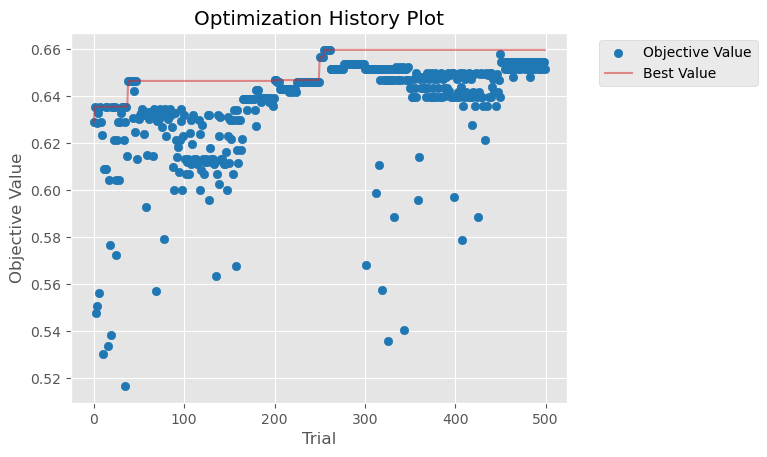

In [130]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

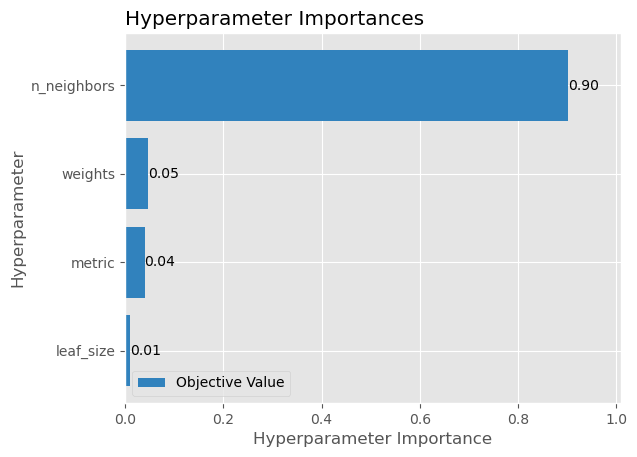

In [131]:

plot_param_importances(study_knn);

In [132]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.661129,0.029776
1,TP,195.400000,5.891614
2,TN,172.700000,8.083591
3,FP,40.400000,2.633122
4,FN,40.700000,5.457920
5,Accuracy,0.819455,0.010744
6,Precision,0.828734,0.008207
7,Sensitivity,0.827878,0.020079
8,Specificity,0.810200,0.014135
9,F1 score,0.828140,0.009078


In [133]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.635546,0.641951,0.676110,0.681134,0.649843,0.634471,0.639424,0.647010,0.656149,0.612768,0.647441,0.020125
1,TP,373.000000,388.000000,369.000000,401.000000,397.000000,375.000000,382.000000,413.000000,399.000000,381.000000,387.800000,14.281301
2,TN,341.000000,325.000000,358.000000,350.000000,337.000000,357.000000,349.000000,326.000000,340.000000,330.000000,341.300000,12.055888
3,FP,85.000000,97.000000,94.000000,70.000000,86.000000,81.000000,80.000000,87.000000,86.000000,113.000000,87.900000,11.532081
4,FN,100.000000,89.000000,78.000000,78.000000,79.000000,86.000000,88.000000,73.000000,74.000000,75.000000,82.000000,8.563488
5,Accuracy,0.794216,0.793103,0.808676,0.835373,0.816463,0.814238,0.813126,0.822024,0.822024,0.790879,0.811012,0.014507
6,Precision,0.814410,0.800000,0.796976,0.851380,0.821946,0.822368,0.826840,0.826000,0.822680,0.771255,0.815386,0.021624
7,Sensitivity,0.788584,0.813417,0.825503,0.837161,0.834034,0.813449,0.812766,0.849794,0.843552,0.835526,0.825379,0.018383
8,Specificity,0.800500,0.770100,0.792000,0.833300,0.796700,0.815100,0.813500,0.789300,0.798100,0.744900,0.795350,0.024554
9,F1 score,0.801289,0.806653,0.810989,0.844211,0.827946,0.817884,0.819742,0.837728,0.832985,0.802105,0.820153,0.015152


In [134]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id, knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL3921050,0,6.17,5.881382,5.788784,5.881382,5.918187,5.806020,5.907626,0.125682
1,CHEMBL270476,1,6.80,6.332799,6.597422,6.320035,6.597422,6.413524,6.510200,0.171357
2,CHEMBL3664128,2,7.62,7.134899,7.185277,7.138537,7.107074,7.141257,7.221174,0.179828
3,CHEMBL4456250,3,5.26,5.953141,6.236653,5.688565,5.953141,5.651759,5.790543,0.306329
4,CHEMBL2408818,4,6.32,6.247131,6.247131,6.247131,6.247131,6.245302,6.258971,0.027301
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4250302,4487,10.25,9.234397,9.224191,9.234397,9.224191,9.228971,9.399358,0.380442
4488,CHEMBL483893,4488,7.83,7.750982,7.831410,7.701820,7.731933,7.796240,7.773731,0.049050
4489,CHEMBL3655914,4489,6.69,6.718561,6.749571,6.718561,6.718561,6.718561,6.718969,0.017206
4490,CHEMBL467876,4490,7.40,7.140000,7.140000,7.140000,7.140000,7.140000,7.183333,0.096896


In [135]:
mat_met_optimized_knn

,Metric,Value (average),Value (std)
0,R2,0.660319,0.033209
1,Accuracy,0.820214,0.018991
2,Precision,0.829614,0.021078
3,Sensitivity,0.828289,0.031439
4,Specificity,0.811450,0.024286
5,F1 score,0.828559,0.019493
6,F1 score (weighted),0.820204,0.018912
7,F1 score (macro),0.819522,0.019002
8,Balanced Accuracy,0.819871,0.018801
9,MCC,0.639908,0.038220


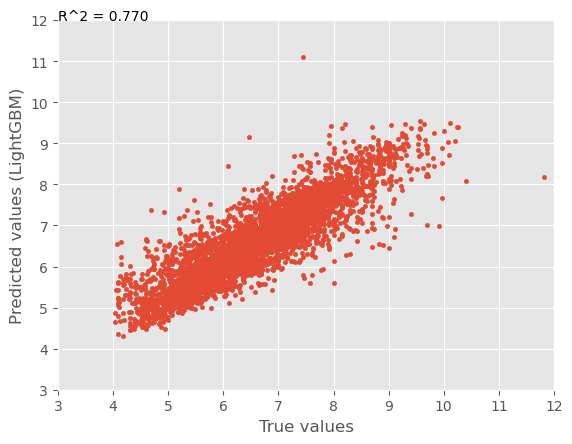

In [137]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (3, 12))
plt.show()

In [138]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6553 with a standard deviation of 0.0199
KNN optimized model r2_score 0.6650 with a standard deviation of 0.0218


In [139]:
joblib.dump(knn_reg, "OUTPUT/knn_reg.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn.joblib")

['OUTPUT/optimizedCV_knn.joblib']

## Support Vector 

In [140]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.684736     0.020457
1                    TP       200.400000     7.515909
2                    TN       173.800000     4.709329
3                    FP        39.300000     4.448470
4                    FN        35.700000     4.029061
5              Accuracy         0.833037     0.011300
6             Precision         0.835924     0.019541
7           Sensitivity         0.848787     0.016122
8           Specificity         0.815910     0.015700
9              F1 score         0.842150     0.013387
10  F1 score (weighted)         0.832979     0.011273
11     F1 score (macro)         0.832367     0.011051
12    Balanced Accuracy         0.832348     0.010790
13                  MCC         0.665184     0.021877
14                  NPV         0.829750     0.016865
15              ROC_AUC         0.832348     0.010790
CPU times: user 44.5 s, sys: 3.9 ms, total: 44.5 s
Wall time: 44.5 s


In [141]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [142]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [143]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:57:46,177] A new study created in memory with name: SVM_regressor_CV
[I 2023-12-20 05:58:13,293] Trial 0 finished with value: 0.6593861304397464 and parameters: {'C': 16.0, 'gamma': 0.00390625}. Best is trial 0 with value: 0.6593861304397464.
[I 2023-12-20 05:58:36,509] Trial 1 finished with value: 0.6566779176516353 and parameters: {'C': 2.0, 'gamma': 0.0078125}. Best is trial 0 with value: 0.6593861304397464.
[I 2023-12-20 05:59:01,269] Trial 2 finished with value: 0.6715341867502411 and parameters: {'C': 64.0, 'gamma': 0.03125}. Best is trial 2 with value: 0.6715341867502411.
[I 2023-12-20 05:59:27,456] Trial 3 finished with value: 0.036476146431117254 and parameters: {'C': 64.0, 'gamma': 2.0}. Best is trial 2 with value: 0.6715341867502411.
[I 2023-12-20 05:59:51,527] Trial 4 finished with value: 0.5626830814991028 and parameters: {'C': 32.0, 'gamma': 0.00048828125}. Best is trial 2 with value: 0.6715341867502411.
[I 2023-12-20 06:00:18,337] Trial 5 finished with v

	Number of trials: 50.0
	Best value (r2_score): 0.6924
	Best params:
		C: 4.0
		gamma: 0.015625


In [144]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_0_cat = np.where((y_pred_svm_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.690919
1                    TP  403.000000
2                    TN  348.000000
3                    FP   78.000000
4                    FN   70.000000
5              Accuracy    0.835373
6             Precision    0.837838
7           Sensitivity    0.852008
8           Specificity    0.816900
9              F1 score    0.844864
10  F1 score (weighted)    0.835283
11     F1 score (macro)    0.834754
12    Balanced Accuracy    0.834455
13                  MCC    0.669641
14                  NPV    0.832500
15              ROC_AUC    0.834455


In [145]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 06:19:03,987] Trial 50 finished with value: 0.10003611793267146 and parameters: {'C': 2.0, 'gamma': 3.0517578125e-05}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:19:29,345] Trial 51 finished with value: 0.6096502729025851 and parameters: {'C': 16.0, 'gamma': 0.001953125}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:19:53,450] Trial 52 finished with value: 0.6816562475411623 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:20:17,704] Trial 53 finished with value: 0.3291300613454229 and parameters: {'C': 8.0, 'gamma': 6.103515625e-05}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:20:41,354] Trial 54 finished with value: 0.005787489501689091 and parameters: {'C': 0.03125, 'gamma': 0.0001220703125}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:21:06,987] Trial 55 finished with value: 0.3175009230124525 and parameters: {'C': 0.0

	Number of trials: 100.0
	Best value (r2_score): 0.6924
	Best params:
		C: 4.0
		gamma: 0.015625


In [146]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_1_cat = np.where((y_pred_svm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.690919    0.729222
1                    TP  403.000000  408.000000
2                    TN  348.000000  348.000000
3                    FP   78.000000   74.000000
4                    FN   70.000000   69.000000
5              Accuracy    0.835373    0.840934
6             Precision    0.837838    0.846473
7           Sensitivity    0.852008    0.855346
8           Specificity    0.816900    0.824600
9              F1 score    0.844864    0.850886
10  F1 score (weighted)    0.835283    0.840875
11     F1 score (macro)    0.834754    0.840223
12    Balanced Accuracy    0.834455    0.839995
13                  MCC    0.669641    0.680498
14                  NPV    0.832500    0.834500
15              ROC_AUC    0.834455    0.839995


In [147]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 06:39:30,218] Trial 100 finished with value: 0.5607542974981008 and parameters: {'C': 64.0, 'gamma': 0.0625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:39:54,985] Trial 101 finished with value: 0.6834547348920956 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:40:21,490] Trial 102 finished with value: 0.6834547348920956 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:40:46,844] Trial 103 finished with value: 0.6834547348920956 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:41:10,528] Trial 104 finished with value: 0.40357758177244474 and parameters: {'C': 1.0, 'gamma': 0.0009765625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 06:41:35,422] Trial 105 finished with value: 0.6846467577772148 and parameters: {'C': 8.0, 'gamma': 0.015625}

	Number of trials: 150.0
	Best value (r2_score): 0.6924
	Best params:
		C: 4.0
		gamma: 0.015625


In [148]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_2_cat = np.where((y_pred_svm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.690919    0.729222    0.719859
1                    TP  403.000000  408.000000  381.000000
2                    TN  348.000000  348.000000  374.000000
3                    FP   78.000000   74.000000   78.000000
4                    FN   70.000000   69.000000   66.000000
5              Accuracy    0.835373    0.840934    0.839822
6             Precision    0.837838    0.846473    0.830065
7           Sensitivity    0.852008    0.855346    0.852349
8           Specificity    0.816900    0.824600    0.827400
9              F1 score    0.844864    0.850886    0.841060
10  F1 score (weighted)    0.835283    0.840875    0.839805
11     F1 score (macro)    0.834754    0.840223    0.839812
12    Balanced Accuracy    0.834455    0.839995    0.839891
13                  MCC    0.669641    0.680498    0.679924
14                  NPV    0.832500    0.834500    0.850000
15              ROC_AUC    0.834455    0

In [149]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 07:01:03,244] Trial 150 finished with value: 0.6845189427911448 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:01:28,218] Trial 151 finished with value: 0.6794152628008806 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:01:54,422] Trial 152 finished with value: 0.6794152628008806 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:02:20,095] Trial 153 finished with value: 0.027749534793615305 and parameters: {'C': 16.0, 'gamma': 4.0}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:02:46,518] Trial 154 finished with value: 0.6794152628008806 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:03:11,712] Trial 155 finished with value: 0.6784690367640496 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best

	Number of trials: 200.0
	Best value (r2_score): 0.6924
	Best params:
		C: 4.0
		gamma: 0.015625


In [150]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_3_cat = np.where((y_pred_svm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.690919    0.729222    0.719859    0.721196
1                    TP  403.000000  408.000000  381.000000  406.000000
2                    TN  348.000000  348.000000  374.000000  354.000000
3                    FP   78.000000   74.000000   78.000000   66.000000
4                    FN   70.000000   69.000000   66.000000   73.000000
5              Accuracy    0.835373    0.840934    0.839822    0.845384
6             Precision    0.837838    0.846473    0.830065    0.860169
7           Sensitivity    0.852008    0.855346    0.852349    0.847599
8           Specificity    0.816900    0.824600    0.827400    0.842900
9              F1 score    0.844864    0.850886    0.841060    0.853838
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865
12    Balanced Accuracy    0.834455    0.839995    0.839891    0

In [151]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 07:21:59,065] Trial 200 finished with value: 0.039119466108999815 and parameters: {'C': 2.0, 'gamma': 4.0}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:22:24,077] Trial 201 finished with value: 0.6860419335322965 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:22:47,816] Trial 202 finished with value: 0.6860419335322965 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:23:15,342] Trial 203 finished with value: 0.6860419335322965 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:23:43,529] Trial 204 finished with value: 0.05165771349843875 and parameters: {'C': 16.0, 'gamma': 1.0}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:24:10,056] Trial 205 finished with value: 0.6860419335322965 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is

	Number of trials: 250.0
	Best value (r2_score): 0.6924
	Best params:
		C: 4.0
		gamma: 0.015625


In [152]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_4_cat = np.where((y_pred_svm_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.690919    0.729222    0.719859    0.721196   
1                    TP  403.000000  408.000000  381.000000  406.000000   
2                    TN  348.000000  348.000000  374.000000  354.000000   
3                    FP   78.000000   74.000000   78.000000   66.000000   
4                    FN   70.000000   69.000000   66.000000   73.000000   
5              Accuracy    0.835373    0.840934    0.839822    0.845384   
6             Precision    0.837838    0.846473    0.830065    0.860169   
7           Sensitivity    0.852008    0.855346    0.852349    0.847599   
8           Specificity    0.816900    0.824600    0.827400    0.842900   
9              F1 score    0.844864    0.850886    0.841060    0.853838   
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454   
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865   
12    Balanced Accuracy  

In [153]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 07:44:01,368] Trial 250 finished with value: 0.5725572227392377 and parameters: {'C': 32.0, 'gamma': 0.00048828125}. Best is trial 44 with value: 0.6923633479626572.
[I 2023-12-20 07:44:28,328] Trial 251 finished with value: 0.7018736313932994 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 07:44:54,171] Trial 252 finished with value: 0.6880213768595599 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 07:45:20,893] Trial 253 finished with value: 0.6880213768595599 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 07:45:47,516] Trial 254 finished with value: 0.6880213768595599 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 07:46:14,318] Trial 255 finished with value: 0.6880213768595599 and parameters: {'C': 8.0, 'gamma': 0.03125}.

	Number of trials: 300.0
	Best value (r2_score): 0.7019
	Best params:
		C: 8.0
		gamma: 0.015625


In [154]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_5_cat = np.where((y_pred_svm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.690919    0.729222    0.719859    0.721196   
1                    TP  403.000000  408.000000  381.000000  406.000000   
2                    TN  348.000000  348.000000  374.000000  354.000000   
3                    FP   78.000000   74.000000   78.000000   66.000000   
4                    FN   70.000000   69.000000   66.000000   73.000000   
5              Accuracy    0.835373    0.840934    0.839822    0.845384   
6             Precision    0.837838    0.846473    0.830065    0.860169   
7           Sensitivity    0.852008    0.855346    0.852349    0.847599   
8           Specificity    0.816900    0.824600    0.827400    0.842900   
9              F1 score    0.844864    0.850886    0.841060    0.853838   
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454   
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865   
12    Balanced Accuracy  

In [155]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 08:05:05,669] Trial 300 finished with value: 0.6805814480357282 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:05:30,432] Trial 301 finished with value: 0.6805814480357282 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:05:57,196] Trial 302 finished with value: 0.2892785299119814 and parameters: {'C': 8.0, 'gamma': 0.125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:06:22,847] Trial 303 finished with value: 0.5137578696120787 and parameters: {'C': 0.25, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:06:52,260] Trial 304 finished with value: 0.6508160745428875 and parameters: {'C': 8.0, 'gamma': 0.00390625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:07:19,294] Trial 305 finished with value: 0.5672682525268754 and parameters: {'C': 2.0, 'gamma': 0.0625}. Best 

	Number of trials: 350.0
	Best value (r2_score): 0.7019
	Best params:
		C: 8.0
		gamma: 0.015625


In [156]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_6_cat = np.where((y_pred_svm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.690919    0.729222    0.719859    0.721196   
1                    TP  403.000000  408.000000  381.000000  406.000000   
2                    TN  348.000000  348.000000  374.000000  354.000000   
3                    FP   78.000000   74.000000   78.000000   66.000000   
4                    FN   70.000000   69.000000   66.000000   73.000000   
5              Accuracy    0.835373    0.840934    0.839822    0.845384   
6             Precision    0.837838    0.846473    0.830065    0.860169   
7           Sensitivity    0.852008    0.855346    0.852349    0.847599   
8           Specificity    0.816900    0.824600    0.827400    0.842900   
9              F1 score    0.844864    0.850886    0.841060    0.853838   
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454   
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865   
12    Balanced Accuracy  

In [157]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 08:27:38,723] Trial 350 finished with value: 0.40988971418304565 and parameters: {'C': 8.0, 'gamma': 0.0001220703125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:28:05,991] Trial 351 finished with value: 0.33328583971337944 and parameters: {'C': 8.0, 'gamma': 6.103515625e-05}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:28:32,065] Trial 352 finished with value: 0.6599622581747567 and parameters: {'C': 1.0, 'gamma': 0.03125}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:28:57,823] Trial 353 finished with value: 0.2497544684044129 and parameters: {'C': 8.0, 'gamma': 3.0517578125e-05}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:29:22,911] Trial 354 finished with value: 0.057561484542022236 and parameters: {'C': 8.0, 'gamma': 0.5}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:29:50,034] Trial 355 finished with value: 0.03705374922743717 and parameters: {'C': 8.0,

	Number of trials: 400.0
	Best value (r2_score): 0.7019
	Best params:
		C: 8.0
		gamma: 0.015625


In [158]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_7_cat = np.where((y_pred_svm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.690919    0.729222    0.719859    0.721196   
1                    TP  403.000000  408.000000  381.000000  406.000000   
2                    TN  348.000000  348.000000  374.000000  354.000000   
3                    FP   78.000000   74.000000   78.000000   66.000000   
4                    FN   70.000000   69.000000   66.000000   73.000000   
5              Accuracy    0.835373    0.840934    0.839822    0.845384   
6             Precision    0.837838    0.846473    0.830065    0.860169   
7           Sensitivity    0.852008    0.855346    0.852349    0.847599   
8           Specificity    0.816900    0.824600    0.827400    0.842900   
9              F1 score    0.844864    0.850886    0.841060    0.853838   
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454   
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865   
12    Balanced Accuracy  

In [159]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 08:48:28,791] Trial 400 finished with value: 0.700200442203562 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:48:52,834] Trial 401 finished with value: 0.700200442203562 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:49:18,383] Trial 402 finished with value: 0.700200442203562 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:49:46,348] Trial 403 finished with value: 0.700200442203562 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:50:13,687] Trial 404 finished with value: 0.700200442203562 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7018736313932994.
[I 2023-12-20 08:50:42,714] Trial 405 finished with value: 0.700200442203562 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best i

	Number of trials: 450.0
	Best value (r2_score): 0.7019
	Best params:
		C: 8.0
		gamma: 0.015625


In [160]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_8_cat = np.where((y_pred_svm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.690919    0.729222    0.719859    0.721196   
1                    TP  403.000000  408.000000  381.000000  406.000000   
2                    TN  348.000000  348.000000  374.000000  354.000000   
3                    FP   78.000000   74.000000   78.000000   66.000000   
4                    FN   70.000000   69.000000   66.000000   73.000000   
5              Accuracy    0.835373    0.840934    0.839822    0.845384   
6             Precision    0.837838    0.846473    0.830065    0.860169   
7           Sensitivity    0.852008    0.855346    0.852349    0.847599   
8           Specificity    0.816900    0.824600    0.827400    0.842900   
9              F1 score    0.844864    0.850886    0.841060    0.853838   
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454   
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865   
12    Balanced Accuracy  

In [161]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 09:07:36,975] Trial 450 finished with value: 0.7055574334986049 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 450 with value: 0.7055574334986049.
[I 2023-12-20 09:07:57,741] Trial 451 finished with value: 0.7055574334986049 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 450 with value: 0.7055574334986049.
[I 2023-12-20 09:08:18,741] Trial 452 finished with value: 0.7055574334986049 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 450 with value: 0.7055574334986049.
[I 2023-12-20 09:08:39,253] Trial 453 finished with value: 0.7055574334986049 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 450 with value: 0.7055574334986049.
[I 2023-12-20 09:08:59,611] Trial 454 finished with value: 0.7055574334986049 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 450 with value: 0.7055574334986049.
[I 2023-12-20 09:09:20,941] Trial 455 finished with value: 0.7055574334986049 and parameters: {'C': 4.0, 'gamma': 0.015625}. 

	Number of trials: 500.0
	Best value (r2_score): 0.7056
	Best params:
		C: 4.0
		gamma: 0.015625


In [162]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_9_cat = np.where((y_pred_svm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.690919    0.729222    0.719859    0.721196   
1                    TP  403.000000  408.000000  381.000000  406.000000   
2                    TN  348.000000  348.000000  374.000000  354.000000   
3                    FP   78.000000   74.000000   78.000000   66.000000   
4                    FN   70.000000   69.000000   66.000000   73.000000   
5              Accuracy    0.835373    0.840934    0.839822    0.845384   
6             Precision    0.837838    0.846473    0.830065    0.860169   
7           Sensitivity    0.852008    0.855346    0.852349    0.847599   
8           Specificity    0.816900    0.824600    0.827400    0.842900   
9              F1 score    0.844864    0.850886    0.841060    0.853838   
10  F1 score (weighted)    0.835283    0.840875    0.839805    0.845454   
11     F1 score (macro)    0.834754    0.840223    0.839812    0.844865   
12    Balanced Accuracy  

In [163]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7056
	Best params:
		C: 4.0
		gamma: 0.015625


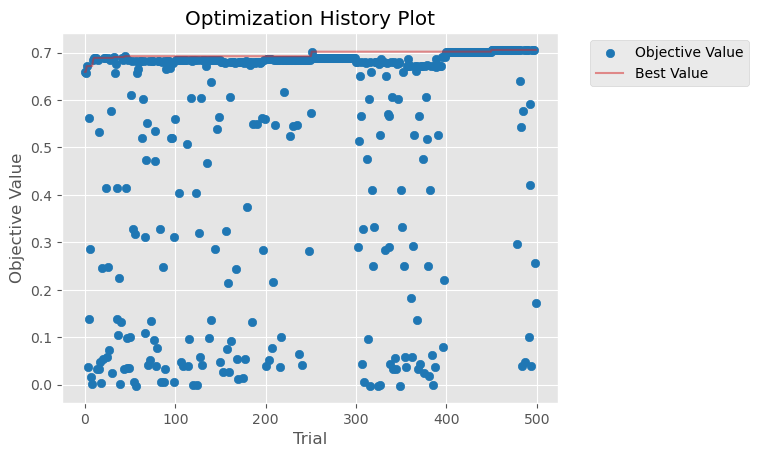

In [164]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [165]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [166]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.717112,0.022899
1,TP,201.200000,7.539525
2,TN,174.900000,4.557046
3,FP,38.200000,4.516636
4,FN,34.900000,4.408325
5,Accuracy,0.837262,0.013800
6,Precision,0.840258,0.020427
7,Sensitivity,0.852201,0.018035
8,Specificity,0.821110,0.016152
9,F1 score,0.846046,0.015470


In [167]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.690919,0.729222,0.719859,0.721196,0.710927,0.691306,0.700637,0.699005,0.697855,0.686044,0.704697,0.014739
1,TP,403.000000,408.000000,381.000000,406.000000,404.000000,395.000000,400.000000,415.000000,408.000000,398.000000,401.800000,9.259230
2,TN,348.000000,348.000000,374.000000,354.000000,344.000000,363.000000,349.000000,343.000000,342.000000,341.000000,350.600000,10.521935
3,FP,78.000000,74.000000,78.000000,66.000000,79.000000,75.000000,80.000000,70.000000,84.000000,102.000000,78.600000,9.697651
4,FN,70.000000,69.000000,66.000000,73.000000,72.000000,66.000000,70.000000,71.000000,65.000000,58.000000,68.000000,4.422166
5,Accuracy,0.835373,0.840934,0.839822,0.845384,0.832036,0.843159,0.833148,0.843159,0.834260,0.822024,0.836930,0.007019
6,Precision,0.837838,0.846473,0.830065,0.860169,0.836439,0.840426,0.833333,0.855670,0.829268,0.796000,0.836568,0.017602
7,Sensitivity,0.852008,0.855346,0.852349,0.847599,0.848739,0.856833,0.851064,0.853909,0.862579,0.872807,0.855323,0.007480
8,Specificity,0.816900,0.824600,0.827400,0.842900,0.813200,0.828800,0.813500,0.830500,0.802800,0.769800,0.817040,0.020040
9,F1 score,0.844864,0.850886,0.841060,0.853838,0.842544,0.848550,0.842105,0.854789,0.845596,0.832636,0.845687,0.006664


In [168]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 



svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id, svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL3921050,0,6.17,5.688394,5.641491,5.702819,5.750936,5.650278,5.767320,0.183640
1,CHEMBL270476,1,6.80,6.488829,6.475655,6.606188,6.577611,6.592361,6.590107,0.106326
2,CHEMBL3664128,2,7.62,7.103311,7.099764,7.116153,7.143908,7.013923,7.182843,0.199512
3,CHEMBL4456250,3,5.26,5.931354,5.970633,5.674359,5.933590,5.693925,5.743977,0.246313
4,CHEMBL2408818,4,6.32,6.139761,6.149006,6.153160,6.132491,6.127830,6.170375,0.067482
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4250302,4487,10.25,9.267433,9.375296,9.331982,9.406212,9.380394,9.501886,0.337503
4488,CHEMBL483893,4488,7.83,7.598687,7.592764,7.533434,7.531419,7.550638,7.606157,0.103519
4489,CHEMBL3655914,4489,6.69,6.337966,6.346410,6.242492,6.346422,6.233569,6.366143,0.152382
4490,CHEMBL467876,4490,7.40,7.239907,7.240081,7.239908,7.240138,7.239870,7.266651,0.059636


In [169]:
mat_met_optimized_svm

,Metric,Value (average),Value (std)
0,R2,0.713483,0.025011
1,Accuracy,0.839981,0.017639
2,Precision,0.846828,0.023409
3,Sensitivity,0.849836,0.026737
4,Specificity,0.829298,0.028402
5,F1 score,0.847938,0.017028
6,F1 score (weighted),0.839942,0.017650
7,F1 score (macro),0.839303,0.017792
8,Balanced Accuracy,0.839567,0.017829
9,MCC,0.679471,0.035712


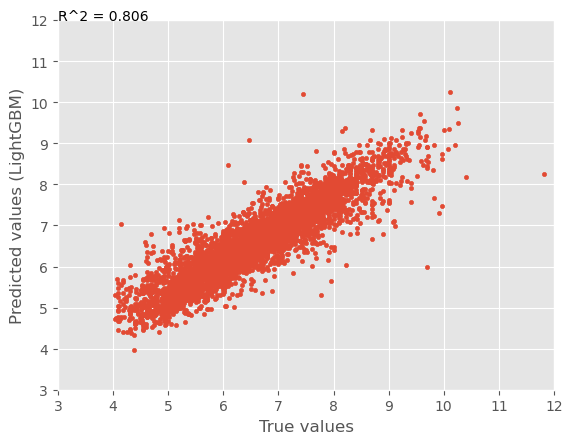

In [171]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (3, 12))
plt.show()

In [172]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.6861 with a standard deviation of 0.0214
SVM optimized model r2_score 0.7140 with a standard deviation of 0.0221


In [173]:
joblib.dump(svm_reg, "OUTPUT/svm_reg.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm.joblib")

['OUTPUT/optimizedCV_svm.joblib']

In [174]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [175]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )

In [176]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/PredResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    rf_5preds.to_excel(writer, sheet_name="RF", )
    lgbm_5preds.to_excel(writer, sheet_name="LGBM", )
    xgb_5preds.to_excel(writer, sheet_name="XGB", )
    knn_5preds.to_excel(writer, sheet_name="KNN", )
    svm_5preds.to_excel(writer, sheet_name="SVM", )